<a href="https://colab.research.google.com/github/marcvonrohr/DeepLearning/blob/main/meta_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1: INFRASTRUCTURE & SETUP

In [9]:
################################################################################
# BLOCK 1: GLOBAL IMPORTS
################################################################################
import os
import sys
import time
import json
import copy
import random
import shutil
import gc
import csv
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.amp import autocast, GradScaler
from torchvision import models, transforms
from PIL import Image
from tqdm.notebook import tqdm

# Optional: Import PEFT library for LoRA
try: import peft
except ImportError:
    !pip install -q peft
    import peft

print("[INFO] Imports loaded successfully.")

[INFO] Imports loaded successfully.


In [10]:
################################################################################
# BLOCK 2: ARCHITECTURE CONFIGURATION
################################################################################
# Select architecture: 'resnet18', 'resnet34', or 'resnet50'
CURRENT_ARCH = 'resnet18'

print(f"[CONFIG] Current Architecture set to: {CURRENT_ARCH}")

[CONFIG] Current Architecture set to: resnet18


# PART 2: DATA PREPARATION

In [11]:
################################################################################
# BLOCK 3: REPRODUCIBILITY SETUP
################################################################################
def set_seed(seed=42):
    """
    Sets the seed for random number generators in Python, NumPy, and PyTorch
    to ensure reproducible results.

    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Deterministic algorithms (optional, might slow down training)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

# Apply seed immediately
set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"[INFO] Global seed set to 42.")
print(f"[INFO] Compute device selected: {DEVICE}")

[INFO] Global seed set to 42.
[INFO] Compute device selected: cuda


In [12]:
################################################################################
# BLOCK 4: GOOGLE DRIVE AND PATH SETUP
################################################################################
if not os.path.exists('/content/drive'):
    from google.colab import drive
    print("[INFO] Mounting Google Drive...")
    drive.mount('/content/drive')

# --- 1. GOOGLE DRIVE PATHS (SOURCE) ---
GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')

# Definition of the source archive on Google Drive
DATASETS_DIR = os.path.join(PROJECT_DIR, 'datasets')
INATURALIST_DIR = os.path.join(DATASETS_DIR, 'inaturalist')
ARCHIVES_DIR = os.path.join(INATURALIST_DIR, 'archives')
SOURCE_TAR_PATH = os.path.join(ARCHIVES_DIR, '2021_train_mini.tar.gz')

PARTITION_FILE = os.path.join(PROJECT_DIR, 'project_meta', 'inat_class_split.json')

# --- 2. LOCAL VM PATHS (DESTINATION) ---
# Fast SSD storage on the Colab Instance
LOCAL_WORK_DIR = '/content/data'
LOCAL_TAR_PATH = os.path.join(LOCAL_WORK_DIR, '2021_train_mini.tar.gz')

# The final directory where images will reside after unpacking
LOCAL_DATA_ROOT = os.path.join(LOCAL_WORK_DIR, 'inaturalist_unpacked')

# --- 3. OUTPUT DIRECTORIES (LOGS & MODELS) ---
# Determine suffix based on architecture
if CURRENT_ARCH == 'resnet18':
    ARCH_SUFFIX = "_r18"
elif CURRENT_ARCH == 'resnet34':
    ARCH_SUFFIX = "_r34"
elif CURRENT_ARCH == 'resnet50':
    ARCH_SUFFIX = "_r50"
else:
    raise ValueError(f"Unsupported architecture: {CURRENT_ARCH}")

DIRS = {
    'BASE_MODELS': os.path.join(PROJECT_DIR, 'models', f'base_models{ARCH_SUFFIX}'),
    'MAML_MODELS': os.path.join(PROJECT_DIR, 'models', f'maml_models{ARCH_SUFFIX}'),
    'LOGS':        os.path.join(PROJECT_DIR, 'logs', f'run{ARCH_SUFFIX}'),
    'PLOTS':       os.path.join(PROJECT_DIR, 'plots', f'run{ARCH_SUFFIX}'),
    'DATA_ROOT':   LOCAL_DATA_ROOT
}

# Create project directories (but not data dir yet)
for key, path in DIRS.items():
    if key != 'DATA_ROOT':
        os.makedirs(path, exist_ok=True)

print(f"[INFO] Directories initialized for {CURRENT_ARCH}:")
for key, path in DIRS.items():
    print(f"   -> {key:<12}: {path}")

print(f"[INFO] Archive Source: {SOURCE_TAR_PATH}")
print(f"[INFO] Archive Target: {LOCAL_TAR_PATH}")

[INFO] Directories initialized for resnet18:
   -> BASE_MODELS : /content/drive/MyDrive/Deep Learning/models/base_models_r18
   -> MAML_MODELS : /content/drive/MyDrive/Deep Learning/models/maml_models_r18
   -> LOGS        : /content/drive/MyDrive/Deep Learning/logs/run_r18
   -> PLOTS       : /content/drive/MyDrive/Deep Learning/plots/run_r18
   -> DATA_ROOT   : /content/data/inaturalist_unpacked
[INFO] Archive Source: /content/drive/MyDrive/Deep Learning/datasets/inaturalist/archives/2021_train_mini.tar.gz
[INFO] Archive Target: /content/data/2021_train_mini.tar.gz


In [13]:
################################################################################
# BLOCK 4b: PREPARE LOCAL VM (COPY & UNZIP)
################################################################################

# Define Local Temporary Paths
# We use the parent directory of the data root for the temporary tar file
local_work_dir = os.path.dirname(DIRS['DATA_ROOT'])
local_tar_path = os.path.join(local_work_dir, '2021_train_mini.tar.gz')

os.makedirs(local_work_dir, exist_ok=True)

print(f"[INFO] Checking Data Status...")
print(f"   -> Source (Drive): {SOURCE_TAR_PATH}")
print(f"   -> Target (VM):    {DIRS['DATA_ROOT']}")

# Check if Data is already present
# We check if the target directory exists and is not empty
data_is_present = False
if os.path.exists(DIRS['DATA_ROOT']):
    if len(os.listdir(DIRS['DATA_ROOT'])) > 0:
        data_is_present = True

if data_is_present:
    print(f"[SKIP] Data directory is already populated.")

else:
    # Copy Archive
    if not os.path.exists(local_tar_path):
        print(f"[ACTION] Copying archive from Drive...")
        if os.path.exists(SOURCE_TAR_PATH):
            start_t = time.time()
            shutil.copy(SOURCE_TAR_PATH, local_tar_path)
            print(f"   -> Copy complete ({time.time() - start_t:.1f}s).")
        else:
            raise FileNotFoundError(f"Source archive not found at {SOURCE_TAR_PATH}")
    else:
        print(f"[INFO] Local tarball already exists. Skipping copy.")

    # Unpack Archive
    print(f"[ACTION] Unpacking data...")
    start_t = time.time()

    # Ensure target directory exists
    os.makedirs(DIRS['DATA_ROOT'], exist_ok=True)

    # Use system tar for maximum speed
    # -x: extract, -z: gzip, -f: file, -C: target directory
    ret_code = os.system(f"tar -xzf \"{local_tar_path}\" -C \"{DIRS['DATA_ROOT']}\"")

    if ret_code == 0:
        print(f"   -> Unpacking complete ({time.time() - start_t:.1f}s).")

        # Cleanup (Save Space)
        print(f"[ACTION] Removing temporary tarball...")
        os.remove(local_tar_path)
    else:
        raise RuntimeError(f"Unpacking failed with return code {ret_code}")

# Verification
print(f"\n[VERIFY] Content of {DIRS['DATA_ROOT']}:")
print(os.listdir(DIRS['DATA_ROOT']))

[INFO] Checking Data Status...
   -> Source (Drive): /content/drive/MyDrive/Deep Learning/datasets/inaturalist/archives/2021_train_mini.tar.gz
   -> Target (VM):    /content/data/inaturalist_unpacked
[ACTION] Copying archive from Drive...
   -> Copy complete (1063.9s).
[ACTION] Unpacking data...
   -> Unpacking complete (429.8s).
[ACTION] Removing temporary tarball...

[VERIFY] Content of /content/data/inaturalist_unpacked:
['train_mini']


In [14]:
################################################################################
# BLOCK 4c: SCIENTIFIC DATA PARTITIONING
################################################################################
print(f"[INFO] Checking Partition File: {PARTITION_FILE}")

# Ensure meta directory exists
os.makedirs(os.path.dirname(PARTITION_FILE), exist_ok=True)

if os.path.exists(PARTITION_FILE):
    print("[INFO] Found existing partition file. Loading...")
    with open(PARTITION_FILE, 'r') as f:
        partition_data = json.load(f)
    print("[OK] Partition loaded.")
else:
    print("[INFO] Creating NEW partition file (Scanning directories)...")

    # Identify Root
    # Look inside DATA_ROOT for the folder containing the actual images
    target_root = DIRS['DATA_ROOT']
    possible_roots = [
        os.path.join(target_root, '2021_train_mini'),
        os.path.join(target_root, 'train_mini'),
        target_root
    ]

    # Find the first directory that exists and is not empty
    DATASET_ROOT = next((p for p in possible_roots if os.path.exists(p) and os.listdir(p)), None)

    if not DATASET_ROOT:
        raise FileNotFoundError(f"Could not find dataset root in {target_root}")

    print(f"[INFO] Scanning images in: {DATASET_ROOT}")

    # Scan
    class_folders_rel = []
    for root, dirs, files in os.walk(DATASET_ROOT):
        # Heuristic: A folder is a class if it contains images
        has_images = any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files)
        if has_images:
            rel_path = os.path.relpath(root, DATASET_ROOT)
            class_folders_rel.append(rel_path)

    # Sort & Split
    # Ensure deterministic order before shuffling
    class_folders_rel.sort()
    num_classes = len(class_folders_rel)
    print(f"[INFO] Found {num_classes} classes.")

    if num_classes < 9900:
        print("[WARN] Found fewer than 10k classes. Check dataset integrity.")

    all_ids = list(range(num_classes))

    # Shuffle using the GLOBAL seed set in Block 3
    random.shuffle(all_ids)

    # 6000 / 2000 / 2000 Split
    c_base = sorted(all_ids[:6000])
    c_val = sorted(all_ids[6000:8000])
    c_novel = sorted(all_ids[8000:])

    # Save
    partition_data = {
        "sets": {
            'c_base': c_base,
            'c_val': c_val,
            'c_novel': c_novel
        },
        "id_to_path": {str(i): p for i, p in enumerate(class_folders_rel)}
    }

    with open(PARTITION_FILE, 'w') as f:
        json.dump(partition_data, f, indent=4)
    print(f"[SUCCESS] Partition saved to {PARTITION_FILE}")

# Verification (Overlap Check)
sets = partition_data['sets']
print(f"   Base: {len(sets['c_base'])} | Val: {len(sets['c_val'])} | Novel: {len(sets['c_novel'])}")

base_set = set(sets['c_base'])
val_set = set(sets['c_val'])
novel_set = set(sets['c_novel'])

overlap_bv = base_set & val_set
overlap_bn = base_set & novel_set
overlap_vn = val_set & novel_set

print(f"[VERIFY] Overlaps (Base-Val):   {len(overlap_bv)}")
print(f"[VERIFY] Overlaps (Base-Novel): {len(overlap_bn)}")
print(f"[VERIFY] Overlaps (Val-Novel):  {len(overlap_vn)}")

if len(overlap_bv) + len(overlap_bn) + len(overlap_vn) == 0:
    print("[SUCCESS] Classes are cleanly partitioned.")
else:
    raise ValueError("[CRITICAL ERROR] Overlaps detected in class sets!")

[INFO] Checking Partition File: /content/drive/MyDrive/Deep Learning/project_meta/inat_class_split.json
[INFO] Found existing partition file. Loading...
[OK] Partition loaded.
   Base: 6000 | Val: 2000 | Novel: 2000
[VERIFY] Overlaps (Base-Val):   0
[VERIFY] Overlaps (Base-Novel): 0
[VERIFY] Overlaps (Val-Novel):  0
[SUCCESS] Classes are cleanly partitioned.


In [15]:
################################################################################
# BLOCK 5: LOGGING INFRASTRUCTURE
################################################################################
class ExperimentLogger:
    """
    Handles logging of experiment details to text files and metrics to CSV files.
    """
    def __init__(self, phase_name, subset_name="Global", is_dry_run=False):
        """
        Initialize the logger.
        Args:
            phase_name (str): e.g., 'PreTraining'
            subset_name (str): e.g., 'M_base_25'
            is_dry_run (bool): If True, appends '_dryrun' to filenames.
        """
        self.phase = phase_name
        self.subset = subset_name
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Dry Run Suffix
        suffix = "_dryrun" if is_dry_run else ""
        self.base_name = f"{phase_name}_{subset_name}_{CURRENT_ARCH}{suffix}"

        # Define file paths
        self.log_file = os.path.join(DIRS['LOGS'], f"{self.base_name}.txt")
        self.csv_metrics = os.path.join(DIRS['LOGS'], f"{self.base_name}_metrics.csv")

        self.metrics_buffer = []

        # Initialize text log
        self.log_msg(f"--- START EXPERIMENT: {self.base_name} ---")
        self.log_msg(f"Timestamp: {self.timestamp}")
        self.log_msg(f"Architecture: {CURRENT_ARCH}")
        self.log_msg(f"Mode: {'DRY RUN' if is_dry_run else 'REAL RUN'}")

    def log_msg(self, msg):
        print(msg)
        with open(self.log_file, 'a') as f:
            f.write(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}\n")

    def log_metric(self, epoch_or_step, **kwargs):
        """
        Records a metric entry. Automatically captures VRAM usage.
        """
        # Capture VRAM usage (GB)
        vram_allocated = 0.0
        vram_reserved = 0.0
        if torch.cuda.is_available():
            vram_allocated = torch.cuda.memory_allocated() / 1e9
            vram_reserved = torch.cuda.memory_reserved() / 1e9

        entry = {
            'timestamp': datetime.now().isoformat(),
            'epoch_step': epoch_or_step,
            'arch': CURRENT_ARCH,
            'phase': self.phase,
            'subset': self.subset,
            'vram_gb_allocated': round(vram_allocated, 2),
            'vram_gb_reserved': round(vram_reserved, 2),
            **kwargs
        }
        self.metrics_buffer.append(entry)

        # Auto-Save to CSV
        pd.DataFrame(self.metrics_buffer).to_csv(self.csv_metrics, index=False)

    def finish(self):
        self.log_msg(f"--- FINISHED: {self.base_name} ---")
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

print("[INFO] Logger Class initialized.")

[INFO] Logger Class initialized.


In [16]:
################################################################################
# BLOCK 6: MODEL FACTORY
################################################################################
def get_model(num_classes, pretrained=True):
    """
    Instantiates the model architecture defined in CURRENT_ARCH.

    Args:
        num_classes (int): Number of output classes for the final layer.
        pretrained (bool): Whether to load ImageNet pre-trained weights.

    Returns:
        torch.nn.Module: The prepared model.
    """
    weights = None

    if CURRENT_ARCH == 'resnet18':
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        in_features = model.fc.in_features

    elif CURRENT_ARCH == 'resnet34':
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        model = models.resnet34(weights=weights)
        in_features = model.fc.in_features

    elif CURRENT_ARCH == 'resnet50':
        weights = models.ResNet50_Weights.DEFAULT if pretrained else None
        model = models.resnet50(weights=weights)
        in_features = model.fc.in_features

    else:
        raise ValueError(f"Unknown architecture: {CURRENT_ARCH}")

    # Replace the classification head
    model.fc = nn.Linear(in_features, num_classes)

    return model

print(f"[INFO] Model Factory ready for: {CURRENT_ARCH}")

[INFO] Model Factory ready for: resnet18


In [17]:
################################################################################
# BLOCK 7: DATASET CLASS DEFINITION
################################################################################
class CachedMetaINatDataset(Dataset):
    """
    A Dataset class that loads image paths from a partition file and optionally
    preloads (caches) resized images into RAM.
    Includes robust path discovery for nested folders.
    """
    def __init__(self, root_dir, partition_file, split='c_base', transform=None, preload=False, img_size=84):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        with open(partition_file, 'r') as f:
            data = json.load(f)

        self.allowed_ids = data['sets'][split]
        self.id_to_path = data['id_to_path']
        self.label_map = {orig: new for new, orig in enumerate(self.allowed_ids)}

        self.samples = []

        # Determine the actual root where images reside.
        # Strategy: Check where the first file of the split is located.
        sample_id = str(self.allowed_ids[0])
        sample_rel_path = self.id_to_path[sample_id] # e.g., "Aves/..."

        possible_roots = [
            root_dir,
            os.path.join(root_dir, 'train_mini'),
            os.path.join(root_dir, '2021_train_mini'),
            os.path.join(root_dir, 'val'),
            os.path.join(root_dir, '2021_valid')
        ]

        real_root = root_dir # Default
        for p in possible_roots:
            test_path = os.path.join(p, sample_rel_path)
            if os.path.exists(test_path):
                real_root = p
                # print(f"[DEBUG] Found images for {split} in: {real_root}")
                break

        # Index files
        missing_count = 0
        for original_id in self.allowed_ids:
            rel_path = self.id_to_path[str(original_id)]
            abs_path = os.path.join(real_root, rel_path)

            if os.path.exists(abs_path):
                # List files in the class folder
                for img in os.listdir(abs_path):
                    if img.lower().endswith(('jpg', 'jpeg', 'png')):
                        self.samples.append({
                            'path': os.path.join(abs_path, img),
                            'label': self.label_map[original_id]
                        })
            else:
                missing_count += 1

        print(f"[INFO] Found {len(self.samples)} images for {split} in '{os.path.basename(real_root)}'.")
        if missing_count > 0:
            print(f"[WARN] Could not find folders for {missing_count} classes in this split.")

        # Preload logic
        self.cache = {}
        self.preload = preload

        if self.preload and len(self.samples) > 0:
            print(f"[RAM] Preloading {len(self.samples)} images ({img_size}px) for split '{split}'...")
            for i, s in enumerate(tqdm(self.samples, desc=f"Caching {split}")):
                try:
                    img = Image.open(s['path']).convert('RGB')
                    img = img.resize((img_size, img_size))
                    self.cache[i] = img
                except Exception as e:
                    print(f"[WARN] Failed to load image {s['path']}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.preload:
            image = self.cache[idx]
        else:
            image = Image.open(self.samples[idx]['path']).convert('RGB')

        label = self.samples[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

print("[INFO] Dataset Class defined.")

[INFO] Dataset Class defined.


In [18]:
################################################################################
# BLOCK 7b: MEMORY MANAGEMENT UTILITIES
################################################################################

def clear_vram():
    """
    Clears the GPU cache (VRAM) and resets peak memory statistics.
    Useful to run between experiments to ensure clean measurements.
    """
    if torch.cuda.is_available():
        # 1. Get current usage for logging
        pre_mem = torch.cuda.memory_allocated()

        # 2. Empty Cache
        torch.cuda.empty_cache()

        # 3. Reset Stats
        torch.cuda.reset_peak_memory_stats()

        post_mem = torch.cuda.memory_allocated()
        diff_mb = (pre_mem - post_mem) / 1e6

        print(f"[VRAM] Cache cleared. Released {diff_mb:.2f} MB.")
        print(f"[VRAM] Current usage: {post_mem / 1e6:.2f} MB.")
    else:
        print("[VRAM] No GPU available. Skipping VRAM cleanup.")

def clear_ram(target_variables=None):
    """
    Clears System RAM by deleting specific heavy variables from the global
    namespace and forcing a Garbage Collection.

    Args:
        target_variables (list[str], optional): List of variable names to delete.
                                                If None, uses a default list of known heavy vars.
    """
    print("[RAM] Starting cleanup...")

    # Default heavy variables in our notebook
    if target_variables is None:
        target_variables = [
            # Datasets
            'GLOBAL_TRAIN_DS', 'GLOBAL_VAL_DS', 'GLOBAL_NOVEL_DS',
            'train_ds', 'val_ds', 'subset_ds',

            # Loaders & Generators
            'train_loader', 'val_loader', 'support_loader', 'query_loader',
            'train_gen', 'val_gen', 'task_gen',

            # Models & Optimizers
            'model', 'base_model', 'meta_model', 'maml_model', 'peft_model',
            'base_model_cpu', 'maml_model_cpu',
            'optimizer', 'meta_optimizer', 'scaler', 'scheduler',

            # Data Tensors
            'tasks_data', 'tasks_labels', 'batch_data', 'batch_labels',
            'sX', 'sY', 'qX', 'qY'
        ]

    deleted_count = 0

    # Delete from global scope
    # Note: We access globals() directly. In Jupyter, this refers to the notebook namespace.
    g = globals()
    for var_name in target_variables:
        if var_name in g:
            del g[var_name]
            deleted_count += 1

    print(f"[RAM] Removed {deleted_count} variables from namespace.")

    # Force Garbage Collection
    gc.collect()
    print("[RAM] Garbage Collection finished.")

def clear_all():
    """
    Wrapper to clear both RAM and VRAM completely.
    """
    clear_ram()
    clear_vram()
    print("[INFO] Full cleanup complete.")

print("[INFO] Memory Management Functions defined: clear_vram(), clear_ram(), clear_all()")

[INFO] Memory Management Functions defined: clear_vram(), clear_ram(), clear_all()


In [19]:
################################################################################
# BLOCK 8: GLOBAL DATA LOADING (RAM CACHE)
################################################################################
# Define standard normalization (ImageNet stats)
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Defines target image size for all experiments (Critical for fair comparison)
# Using 128px as decided in Phase 5/6 discussions
TARGET_IMG_SIZE = 128

# Standard Transform (applied AFTER fetching from RAM cache)
global_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

print(">>> STARTING GLOBAL DATA LOAD (This may take a few minutes) <<<")

# 1. Load Training Data (C_base)
# Used for Phase 4 (Pre-Training) and Phase 5 (MAML Training)
if 'GLOBAL_TRAIN_DS' not in globals():
    GLOBAL_TRAIN_DS = CachedMetaINatDataset(
        root_dir=DIRS['DATA_ROOT'],
        partition_file=PARTITION_FILE,
        split='c_base',
        transform=global_transform,
        preload=True,
        img_size=TARGET_IMG_SIZE
    )
else:
    print("[INFO] GLOBAL_TRAIN_DS already in memory.")

# 2. Load Validation Data (C_val)
# Used for Phase 5.2 (MAML Tuning) and Phase 6 (FT/LoRA Tuning)
if 'GLOBAL_VAL_DS' not in globals():
    GLOBAL_VAL_DS = CachedMetaINatDataset(
        root_dir=DIRS['DATA_ROOT'],
        partition_file=PARTITION_FILE,
        split='c_val',
        transform=global_transform,
        preload=True,
        img_size=TARGET_IMG_SIZE
    )
else:
    print("[INFO] GLOBAL_VAL_DS already in memory.")

# 3. Load Test Data (C_novel)
# Used for Phase 7 (Final Evaluation)
if 'GLOBAL_NOVEL_DS' not in globals():
    GLOBAL_NOVEL_DS = CachedMetaINatDataset(
        root_dir=DIRS['DATA_ROOT'],
        partition_file=PARTITION_FILE,
        split='c_novel',
        transform=global_transform,
        preload=True,
        img_size=TARGET_IMG_SIZE
    )
else:
    print("[INFO] GLOBAL_NOVEL_DS already in memory.")

print("\n>>> ALL DATASETS LOADED INTO RAM SUCCESSFULLY <<<")

>>> STARTING GLOBAL DATA LOAD (This may take a few minutes) <<<
[INFO] Found 300000 images for c_base in 'train_mini'.
[RAM] Preloading 300000 images (128px) for split 'c_base'...


Caching c_base:   0%|          | 0/300000 [00:00<?, ?it/s]

[INFO] Found 100000 images for c_val in 'train_mini'.
[RAM] Preloading 100000 images (128px) for split 'c_val'...


Caching c_val:   0%|          | 0/100000 [00:00<?, ?it/s]

[INFO] Found 100000 images for c_novel in 'train_mini'.
[RAM] Preloading 100000 images (128px) for split 'c_novel'...


Caching c_novel:   0%|          | 0/100000 [00:00<?, ?it/s]


>>> ALL DATASETS LOADED INTO RAM SUCCESSFULLY <<<


# PART 3: SHARED UTILITIES

In [20]:
################################################################################
# BLOCK 9a: STANDARD PRE-TRAINING LOADER
################################################################################

def get_pretraining_loader(dataset, fraction, batch_size, num_workers=0):
    """
    Creates standard DataLoaders for Phase 4 (Pre-Training).
    Filters the global dataset based on the requested fraction.
    """
    # 1. Determine subset limit
    total_classes = len(dataset.allowed_ids)
    target_classes = int(total_classes * fraction)

    print(f"[LOADER] Creating Pre-Training Loader for {fraction*100}% ({target_classes} classes)...")

    # 2. Filter indices (0..target-1)
    # Since we remapped labels to 0..N-1 in Block 7, we can simply check the label value
    indices = [i for i, s in enumerate(dataset.samples) if s['label'] < target_classes]

    print(f"   -> Selected {len(indices)} images out of {len(dataset)}.")

    # 3. Create Subset
    subset_ds = torch.utils.data.Subset(dataset, indices)

    # 4. Split Train/Val (90/10)
    val_size = int(0.1 * len(subset_ds))
    train_size = len(subset_ds) - val_size

    train_ds, val_ds = random_split(subset_ds, [train_size, val_size],
                                    generator=torch.Generator().manual_seed(42))

    # 5. Create Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, target_classes

print("[INFO] Pre-Training Loader Factory defined.")

[INFO] Pre-Training Loader Factory defined.


In [21]:
################################################################################
# BLOCK 9b: MAML TASK GENERATORS
################################################################################

class EpisodicTaskGenerator:
    """
    Standard N-Way K-Shot task sampler.
    Used for validation and single-task fetching.
    """
    def __init__(self, dataset, ways, shots, query_shots):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        # Indexing: Map label -> list of image indices
        self.indices_by_label = {}

        print(f"[INFO] Indexing dataset for TaskGenerator...")
        for idx in range(len(dataset)):
            # Access label directly based on dataset type
            if hasattr(dataset, 'samples'):
                label = dataset.samples[idx]['label']
            else:
                _, label = dataset[idx]

            if label not in self.indices_by_label:
                self.indices_by_label[label] = []
            self.indices_by_label[label].append(idx)

        self.classes = list(self.indices_by_label.keys())

    def get_task(self):
        """
        Samples one N-Way K-Shot task.
        Returns stacked tensors: (Support_X, Support_Y, Query_X, Query_Y)
        """
        selected_classes = random.sample(self.classes, self.ways)

        s_imgs, s_lbls = [], []
        q_imgs, q_lbls = [], []

        for local_label, global_label in enumerate(selected_classes):
            indices = self.indices_by_label[global_label]
            needed = self.shots + self.query_shots

            if len(indices) >= needed:
                selected_indices = random.sample(indices, needed)
            else:
                selected_indices = random.choices(indices, k=needed)

            # Support Set
            for k in range(self.shots):
                idx = selected_indices[k]
                img, _ = self.dataset[idx]
                s_imgs.append(img)
                s_lbls.append(local_label)

            # Query Set
            for k in range(self.shots, needed):
                idx = selected_indices[k]
                img, _ = self.dataset[idx]
                q_imgs.append(img)
                q_lbls.append(local_label)

        return (
            torch.stack(s_imgs),
            torch.tensor(s_lbls),
            torch.stack(q_imgs),
            torch.tensor(q_lbls)
        )

class BatchTaskGenerator(EpisodicTaskGenerator):
    """
    High-Performance Generator optimized for A100.
    Fetches a whole batch of tasks at once.
    """
    def sample_batch(self, batch_size):
        all_data, all_labels = [], []

        for _ in range(batch_size):
            sX, sY, qX, qY = self.get_task()

            # Combine images per task: [Ways*(S+Q), C, H, W]
            task_imgs = torch.cat([sX, qX])
            task_lbls = torch.cat([sY, qY])

            all_data.append(task_imgs)
            all_labels.append(task_lbls)

        return torch.stack(all_data), torch.stack(all_labels)

print("[INFO] MAML Task Generators defined.")

[INFO] MAML Task Generators defined.


In [22]:
################################################################################
# BLOCK 9c: FIXED FEW-SHOT LOADER (LOADER for FT/LoRA)
################################################################################

def get_fixed_few_shot_task(dataset, ways, shots, query_shots, seed=None):
    """
    Creates ONE static, fixed Few-Shot task (Support & Query Loaders).
    Used in Phase 6 (Tuning) and Phase 7 (Evaluation).
    """
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)

    # 1. Indexing
    indices_by_label = {}
    for idx in range(len(dataset)):
        if hasattr(dataset, 'samples'):
            label = dataset.samples[idx]['label']
        else:
            _, label = dataset[idx]

        if label not in indices_by_label:
            indices_by_label[label] = []
        indices_by_label[label].append(idx)

    available_classes = list(indices_by_label.keys())

    # 2. Sampling
    selected_classes = random.sample(available_classes, ways)

    support_indices = []
    query_indices = []

    for cls in selected_classes:
        idxs = indices_by_label[cls]
        needed = shots + query_shots

        if len(idxs) >= needed:
            selected = random.sample(idxs, needed)
        else:
            # Safety fallback for very small classes (rare in iNat mini)
            selected = random.choices(idxs, k=needed)

        support_indices.extend(selected[:shots])
        query_indices.extend(selected[shots:])

    # 3. Create Subsets
    support_set = torch.utils.data.Subset(dataset, support_indices)
    query_set = torch.utils.data.Subset(dataset, query_indices)

    # 4. Create Loaders
    # Support Loader: Full Batch (batch_size = len) for stability
    support_loader = DataLoader(support_set, batch_size=len(support_set), shuffle=True)
    query_loader = DataLoader(query_set, batch_size=32, shuffle=False)

    return support_loader, query_loader

print("[INFO] Few-Shot Loader Factory defined.")

[INFO] Few-Shot Loader Factory defined.


In [23]:
################################################################################
# BLOCK 10: SYSTEM VERIFICATION
################################################################################
print("\n--- SYSTEM VERIFICATION ---")

# 1. Check RAM Loading for ALL splits
datasets_loaded = (
    'GLOBAL_TRAIN_DS' in globals() and
    'GLOBAL_VAL_DS' in globals() and
    'GLOBAL_NOVEL_DS' in globals()
)

if datasets_loaded:
    print(f"[OK] Training Data (C_base) in RAM: {len(GLOBAL_TRAIN_DS)} images")
    print(f"[OK] Validation Data (C_val) in RAM: {len(GLOBAL_VAL_DS)} images")
    print(f"[OK] Test Data (C_novel) in RAM:     {len(GLOBAL_NOVEL_DS)} images")

    # --- CHECK A: PRE-TRAINING LOADER ---
    try:
        print("\n[TEST] Checking Pre-Training Loader (Loader A)...")
        # Test with 25% subset logic
        tl, vl, num_c = get_pretraining_loader(GLOBAL_TRAIN_DS, 0.25, batch_size=4)
        print(f"   -> Found {num_c} classes (Expected: 1500)")
        batch = next(iter(tl))
        print(f"   -> Batch Shape: {batch[0].shape} (Expected: [4, 3, 128, 128])")
        print("   -> [OK] Pre-Training Loader works.")
    except Exception as e:
        print(f"   -> [ERROR] Pre-Training Loader failed: {e}")
        import traceback
        traceback.print_exc()

    # --- CHECK B: MAML GENERATOR ---
    try:
        print("\n[TEST] Checking MAML Batch Generator (Loader B)...")
        # Test with 5-Way 1-Shot
        test_gen = BatchTaskGenerator(GLOBAL_TRAIN_DS, ways=5, shots=1, query_shots=1)
        batch_data, batch_labels = test_gen.sample_batch(2) # Get 2 tasks
        # Shape: [MetaBatch, N*(S+Q), C, H, W] -> [2, 10, 3, 128, 128]
        print(f"   -> Batch Shape: {batch_data.shape}")
        print("   -> [OK] MAML Generator works.")
    except Exception as e:
        print(f"   -> [ERROR] MAML Generator failed: {e}")

    # --- CHECK C: FT/LORA LOADER ---
    try:
        print("\n[TEST] Checking FT/LoRA Loader (Loader C)...")
        # Test on C_novel (Real use case)
        supp_dl, query_dl = get_fixed_few_shot_task(GLOBAL_NOVEL_DS, ways=5, shots=5, query_shots=15)

        # Support set should be full batch (5*5 = 25 images)
        s_batch, s_label = next(iter(supp_dl))
        print(f"   -> Support Batch Shape: {s_batch.shape} (Expected: [25, 3, 128, 128])")

        # Query set usually batched by 32
        q_batch, q_label = next(iter(query_dl))
        print(f"   -> Query Batch Shape:   {q_batch.shape}")
        print("   -> [OK] FT/LoRA Loader works.")
    except Exception as e:
        print(f"   -> [ERROR] FT/LoRA Loader failed: {e}")

else:
    print("[ERROR] Global Datasets not found in RAM. Please run Block 8.")

# 2. Check GPU
print("\n[Hardware Check]")
if torch.cuda.is_available():
    print(f"   -> GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   -> VRAM Used: {torch.cuda.memory_allocated()/1e9:.2f} GB")
else:
    print("   -> [WARN] No GPU detected. Training will be slow.")

print("-" * 30)


--- SYSTEM VERIFICATION ---
[OK] Training Data (C_base) in RAM: 300000 images
[OK] Validation Data (C_val) in RAM: 100000 images
[OK] Test Data (C_novel) in RAM:     100000 images

[TEST] Checking Pre-Training Loader (Loader A)...
[LOADER] Creating Pre-Training Loader for 25.0% (1500 classes)...
   -> Selected 75000 images out of 300000.
   -> Found 1500 classes (Expected: 1500)
   -> Batch Shape: torch.Size([4, 3, 128, 128]) (Expected: [4, 3, 128, 128])
   -> [OK] Pre-Training Loader works.

[TEST] Checking MAML Batch Generator (Loader B)...
[INFO] Indexing dataset for TaskGenerator...
   -> Batch Shape: torch.Size([2, 10, 3, 128, 128])
   -> [OK] MAML Generator works.

[TEST] Checking FT/LoRA Loader (Loader C)...
   -> Support Batch Shape: torch.Size([25, 3, 128, 128]) (Expected: [25, 3, 128, 128])
   -> Query Batch Shape:   torch.Size([32, 3, 128, 128])
   -> [OK] FT/LoRA Loader works.

[Hardware Check]
   -> GPU Available: NVIDIA A100-SXM4-40GB
   -> VRAM Used: 0.00 GB
-----------

# PART 4: PRE-TRAINING

In [ ]:
################################################################################
# PART 4: PRE-TRAINING
################################################################################

print(f"\n--- STARTING PHASE 4: PRE-TRAINING ({CURRENT_ARCH}) ---")

# --- 1. CONFIGURATION ---
P4_CONFIG = {
    'LR': 1e-3,
    'EPOCHS': 20,
    'PATIENCE': 5,
    'SUBSETS': [0.25, 0.50, 1.0],
    'BATCH_SIZE': 256,
    'DRY_RUN': False
}

if P4_CONFIG['DRY_RUN']:
    P4_CONFIG['EPOCHS'] = 2
    print("[MODE] DRY RUN ACTIVE (2 Epochs)")

# --- 2. DATA LOADER HELPER ---
def get_subset_loader(fraction, batch_size):
    """
    Creates loaders from the GLOBAL_TRAIN_DS in RAM.
    Uses shallow copy to apply Augmentation only for this phase.
    """
    # 1. Shallow copy global dataset to modify transform without duplicating RAM data
    base_ds = copy.copy(GLOBAL_TRAIN_DS)

    # 2. Define Augmentation
    # Safety: Check if cache is populated
    if not base_ds.cache:
        raise ValueError("Dataset cache is empty! Did you run Block 8?")

    img_size = base_ds.cache[0].size[0] # Detect size from cache

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 3. Filter Indices for Subset
    total_classes = len(base_ds.allowed_ids)
    target_classes = int(total_classes * fraction)

    print(f"[LOADER] Creating Subset {fraction*100}% ({target_classes} classes)...")

    subset_indices = [i for i, s in enumerate(base_ds.samples) if s['label'] < target_classes]

    # 4. Create Train/Val Split
    val_len = int(0.1 * len(subset_indices))
    train_len = len(subset_indices) - val_len

    train_idx, val_idx = random_split(subset_indices, [train_len, val_len])

    # 5. Create Wrapper Datasets
    class TransformedSubset(Dataset):
        def __init__(self, underlying_ds, indices, transform):
            self.ds = underlying_ds
            self.indices = indices
            self.transform = transform
        def __len__(self): return len(self.indices)
        def __getitem__(self, idx):
            real_idx = self.indices[idx]
            img = self.ds.cache[real_idx]
            lbl = self.ds.samples[real_idx]['label']
            return self.transform(img), lbl

    train_ds = TransformedSubset(base_ds, train_idx, train_transform)
    val_ds = TransformedSubset(base_ds, val_idx, val_transform)

    # 6. Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)

    return train_loader, val_loader, target_classes

# --- 3. TRAINING ENGINE ---
def run_pretraining(fraction):
    subset_name = f"M_base_{int(fraction*100)}"
    logger = ExperimentLogger("PreTraining", subset_name, is_dry_run=P4_CONFIG['DRY_RUN'])

    logger.log_msg(f"--- CONFIGURATION DUMP ---")
    logger.log_msg(f"Architecture: {CURRENT_ARCH}")
    logger.log_msg(f"Device: {DEVICE}")
    for k, v in P4_CONFIG.items():
        logger.log_msg(f"{k}: {v}")
    logger.log_msg(f"--------------------------")

    # Ensure Directory Exists
    if not os.path.exists(DIRS['BASE_MODELS']):
        print(f"[INFO] Creating missing directory: {DIRS['BASE_MODELS']}")
        os.makedirs(DIRS['BASE_MODELS'], exist_ok=True)

    # 1. Data & Model
    train_loader, val_loader, num_cls = get_subset_loader(fraction, P4_CONFIG['BATCH_SIZE'])
    model = get_model(num_cls, pretrained=True).to(DEVICE)

    # 2. Optimization
    optimizer = optim.Adam(model.parameters(), lr=P4_CONFIG['LR'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    criterion = nn.CrossEntropyLoss()

    # AMP Scaler
    scaler = torch.amp.GradScaler('cuda')

    # 3. Resume Logic
    run_tag = "_dryrun" if P4_CONFIG['DRY_RUN'] else ""
    ckpt_path = os.path.join(DIRS['BASE_MODELS'], f"{subset_name}{run_tag}_checkpoint.pth")
    best_path = os.path.join(DIRS['BASE_MODELS'], f"{subset_name}{run_tag}_best.pth")

    start_epoch = 0
    best_acc = -1.0

    if os.path.exists(ckpt_path):
        logger.log_msg(f"[RESUME] Found checkpoint: {ckpt_path}")
        try:
            ckpt = torch.load(ckpt_path, map_location=DEVICE)
            prev_epoch = ckpt['epoch']
            prev_best = ckpt.get('best_acc', 0.0)

            if P4_CONFIG['DRY_RUN']:
                logger.log_msg("[INFO] Dry Run: Resetting epoch loop to 0.")
                start_epoch = 0
                best_acc = prev_best
            else:
                if prev_epoch >= P4_CONFIG['EPOCHS'] - 1:
                    logger.log_msg(f"[SKIP] Model already finished ({prev_epoch+1}/{P4_CONFIG['EPOCHS']} Epochs). Best Acc: {prev_best:.4f}")
                    return

                start_epoch = prev_epoch + 1
                best_acc = prev_best
                model.load_state_dict(ckpt['model_state_dict'])
                optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                logger.log_msg(f"[RESUME] Resuming from Epoch {start_epoch+1}. Current Best Acc: {best_acc:.4f}")

        except Exception as e:
            logger.log_msg(f"[WARN] Checkpoint corrupt ({e}). Starting fresh.")

    # 4. Loop
    patience_counter = 0

    for epoch in range(start_epoch, P4_CONFIG['EPOCHS']):
        model.train()
        t_loss, t_corr, t_total = 0, 0, 0
        start_t = time.time()

        pbar = tqdm(train_loader, desc=f"{subset_name} Ep {epoch+1}", leave=False)
        for imgs, lbls in pbar:
            if P4_CONFIG['DRY_RUN'] and t_total > 0: break

            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                out = model(imgs)
                loss = criterion(out, lbls)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            t_loss += loss.item() * imgs.size(0)
            _, pred = torch.max(out, 1)
            t_corr += (pred == lbls).sum().item()
            t_total += imgs.size(0)
            pbar.set_postfix(loss=loss.item())

        train_loss = t_loss / t_total
        train_acc = t_corr / t_total

        # Val
        model.eval()
        v_loss, v_corr, v_total = 0, 0, 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                if P4_CONFIG['DRY_RUN'] and v_total > 0: break
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                out = model(imgs)
                loss = criterion(out, lbls)
                _, pred = torch.max(out, 1)
                v_loss += loss.item() * imgs.size(0)
                v_corr += (pred == lbls).sum().item()
                v_total += imgs.size(0)

        val_loss = v_loss / v_total
        val_acc = v_corr / v_total
        duration = time.time() - start_t
        current_lr = optimizer.param_groups[0]['lr']

        # Scheduler
        scheduler.step(val_loss)

        # LOGGING
        logger.log_msg(f"Ep {epoch+1}/{P4_CONFIG['EPOCHS']} | T_Loss {train_loss:.4f} Acc {train_acc:.4f} | V_Loss {val_loss:.4f} Acc {val_acc:.4f} | Time: {duration:.1f}s")

        logger.log_metric(
            epoch+1,
            train_loss=train_loss,
            train_acc=train_acc,
            val_loss=val_loss,
            val_acc=val_acc,
            duration=duration,
            lr=current_lr
        )

        # Checkpointing
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }
        torch.save(state, ckpt_path)

        # Save Best
        save_cond = (val_acc > best_acc)
        if P4_CONFIG['DRY_RUN']: save_cond = True

        if save_cond:
            best_acc = val_acc
            torch.save(model.state_dict(), best_path)
            logger.log_msg(f"   --> New Best Saved: {best_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        if not P4_CONFIG['DRY_RUN'] and patience_counter >= P4_CONFIG['PATIENCE']:
            logger.log_msg(f"[STOP] Early stopping triggered.")
            break

        clear_vram()

    logger.finish()
    del model, optimizer, train_loader, val_loader
    clear_vram()

# --- 4. EXECUTION LOOP ---
for frac in P4_CONFIG['SUBSETS']:
    try:
        run_pretraining(frac)
    except Exception as e:
        print(f"[ERROR] Run failed for {frac}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n--- FINISHED PART 4: PRE-TRAINING ({CURRENT_ARCH}) ---")


--- STARTING PHASE 4: PRE-TRAINING (resnet18) ---
[MODE] DRY RUN ACTIVE (2 Epochs)
--- START EXPERIMENT: PreTraining_M_base_25_resnet18_dryrun ---
Timestamp: 20251130_170047
Architecture: resnet18
Mode: DRY RUN
--- CONFIGURATION DUMP ---
Architecture: resnet18
Device: cuda
LR: 0.001
EPOCHS: 2
PATIENCE: 5
SUBSETS: [0.25, 0.5, 1.0]
BATCH_SIZE: 256
DRY_RUN: True
--------------------------
[LOADER] Creating Subset 25.0% (1500 classes)...
[RESUME] Found checkpoint: /content/drive/MyDrive/Deep Learning/models/base_models_r18/M_base_25_dryrun_checkpoint.pth
[INFO] Dry Run: Resetting epoch loop to 0.


M_base_25 Ep 1:   0%|          | 0/264 [00:00<?, ?it/s]

Ep 1/2 | T_Loss 7.6635 Acc 0.0000 | V_Loss 7.9110 Acc 0.0039 | Time: 4.9s
   --> New Best Saved: 0.0039
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1703.58 MB.


M_base_25 Ep 2:   0%|          | 0/264 [00:00<?, ?it/s]

Ep 2/2 | T_Loss 7.6129 Acc 0.0000 | V_Loss 8.2429 Acc 0.0039 | Time: 4.8s
   --> New Best Saved: 0.0039
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1702.72 MB.
--- FINISHED: PreTraining_M_base_25_resnet18_dryrun ---
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1702.72 MB.
--- START EXPERIMENT: PreTraining_M_base_50_resnet18_dryrun ---
Timestamp: 20251130_170058
Architecture: resnet18
Mode: DRY RUN
--- CONFIGURATION DUMP ---
Architecture: resnet18
Device: cuda
LR: 0.001
EPOCHS: 2
PATIENCE: 5
SUBSETS: [0.25, 0.5, 1.0]
BATCH_SIZE: 256
DRY_RUN: True
--------------------------
[LOADER] Creating Subset 50.0% (3000 classes)...
[RESUME] Found checkpoint: /content/drive/MyDrive/Deep Learning/models/base_models_r18/M_base_50_dryrun_checkpoint.pth
[INFO] Dry Run: Resetting epoch loop to 0.


M_base_50 Ep 1:   0%|          | 0/528 [00:00<?, ?it/s]

Ep 1/2 | T_Loss 8.4438 Acc 0.0000 | V_Loss 8.5468 Acc 0.0000 | Time: 4.8s
   --> New Best Saved: 0.0000
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1876.15 MB.


M_base_50 Ep 2:   0%|          | 0/528 [00:00<?, ?it/s]

Ep 2/2 | T_Loss 8.2996 Acc 0.0000 | V_Loss 8.6383 Acc 0.0000 | Time: 4.8s
   --> New Best Saved: 0.0000
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1877.24 MB.
--- FINISHED: PreTraining_M_base_50_resnet18_dryrun ---
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1877.24 MB.
--- START EXPERIMENT: PreTraining_M_base_100_resnet18_dryrun ---
Timestamp: 20251130_170112
Architecture: resnet18
Mode: DRY RUN
--- CONFIGURATION DUMP ---
Architecture: resnet18
Device: cuda
LR: 0.001
EPOCHS: 2
PATIENCE: 5
SUBSETS: [0.25, 0.5, 1.0]
BATCH_SIZE: 256
DRY_RUN: True
--------------------------
[LOADER] Creating Subset 100.0% (6000 classes)...
[RESUME] Found checkpoint: /content/drive/MyDrive/Deep Learning/models/base_models_r18/M_base_100_dryrun_checkpoint.pth
[INFO] Dry Run: Resetting epoch loop to 0.


M_base_100 Ep 1:   0%|          | 0/1055 [00:00<?, ?it/s]

Ep 1/2 | T_Loss 9.0130 Acc 0.0000 | V_Loss 9.0921 Acc 0.0000 | Time: 4.9s
   --> New Best Saved: 0.0000
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1773.60 MB.


M_base_100 Ep 2:   0%|          | 0/1055 [00:00<?, ?it/s]

Ep 2/2 | T_Loss 8.9938 Acc 0.0000 | V_Loss 9.2808 Acc 0.0000 | Time: 4.9s
   --> New Best Saved: 0.0000
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1773.89 MB.
--- FINISHED: PreTraining_M_base_100_resnet18_dryrun ---
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 1773.89 MB.

--- FINISHED PART 4: PRE-TRAINING (resnet18) ---


# PART 5: MAML Training



--- STARTING PART 5a: MAML TUNING (resnet18) ---
[MODE] DRY RUN ACTIVE
--- START EXPERIMENT: MAML_Tuning_M_base_25_resnet18_dryrun ---
Timestamp: 20251130_173911
Architecture: resnet18
Mode: DRY RUN
Tuning Enabled. Starting Grid Search on 8 combos...


Total Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Score: 0.2075
 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Score: 0.2075
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Score: 0.2000
 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Score: 0.2000
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Score: 0.2000
 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Score: 0.2000
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Score: 0.2000
 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Score: 0.2000
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Score: 0.0000
 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Score: 0.0000
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Score: 0.0075
 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Score: 0.0075
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Score: 0.2000
 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Score: 0.2000
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...


Tuning:   0%|          | 0/5 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Score: 0.2000
 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Score: 0.2000

RESULTS RANKING:
   META_LR  INNER_LR  INNER_STEPS   Score
0   0.0010      0.10            1  0.2075
1   0.0010      0.10            5  0.2000
2   0.0010      0.01            1  0.2000
3   0.0010      0.01            5  0.2000
7   0.0001      0.01            5  0.2000
6   0.0001      0.01            1  0.2000
5   0.0001      0.10            5  0.0075
4   0.0001      0.10            1  0.0000
Results saved to /content/drive/MyDrive/Deep Learning/logs/run_r18/MAML_Tuning_Results_resnet18_dryrun.csv


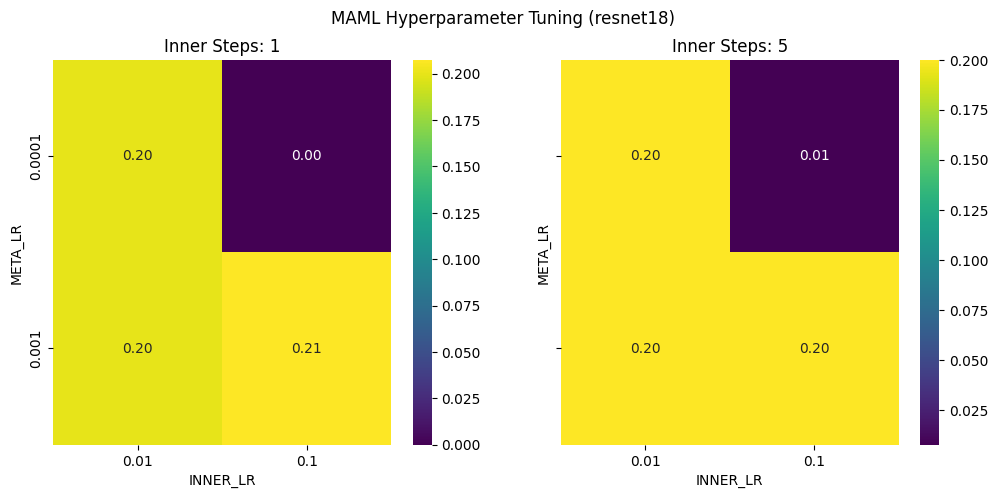


WINNER: MetaLR=0.001, InnerLR=0.1, Steps=1
--- FINISHED: MAML_Tuning_M_base_25_resnet18_dryrun ---


In [ ]:
################################################################################
# PART 5a: MAML HYPERPARAMETER TUNING (SKIPPABLE)
################################################################################
import itertools
from torch.amp import autocast

print(f"\n--- STARTING PART 5a: MAML TUNING ({CURRENT_ARCH}) ---")

# --- 1. CONFIGURATION ---
TUNING_CONFIG = {
    'ENABLED': False,
    'DRY_RUN': False,

    'SUBSET': 0.25,         # Tune on smallest subset
    'ITERS': 200,
    'META_BATCH': 32,
    'VAL_INT': 50,
}

if TUNING_CONFIG['DRY_RUN']:
    TUNING_CONFIG['ITERS'] = 5
    TUNING_CONFIG['VAL_INT'] = 1
    TUNING_CONFIG['META_BATCH'] = 2
    print("[MODE] DRY RUN ACTIVE")

# Search Space
GRID_SEARCH = {
    'META_LR': [1e-3, 1e-4],
    'INNER_LR': [0.1, 0.01],
    'INNER_STEPS': [1, 5]
}

# Init Logger with correct Dry Run flag
# This handles the main log file naming
logger = ExperimentLogger("MAML_Tuning", f"M_base_{int(TUNING_CONFIG['SUBSET']*100)}", is_dry_run=TUNING_CONFIG['DRY_RUN'])


# --- 2. MAML STEP ENGINE ---
def run_tuning_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, cfg):
    meta_loss_total = 0.0
    meta_optimizer.zero_grad()

    inner_lr = cfg['INNER_LR']
    inner_steps = cfg['INNER_STEPS']
    batch_size = tasks_data.shape[0]

    # Pre-calculate indices for 5-Way 5-Shot 15-Query
    ways, shots, queries = 5, 5, 15
    support_idx, query_idx = [], []
    for w in range(ways):
        base = w * (shots + queries)
        support_idx.extend(range(base, base + shots))
        query_idx.extend(range(base + shots, base + shots + queries))

    for i in range(batch_size):
        supp_X = tasks_data[i][support_idx]
        supp_y = tasks_labels[i][support_idx]
        query_X = tasks_data[i][query_idx]
        query_y = tasks_labels[i][query_idx]

        fast_model = copy.deepcopy(meta_model)
        fast_model.train()
        inner_opt = optim.SGD(fast_model.parameters(), lr=inner_lr)

        for _ in range(inner_steps):
            preds = fast_model(supp_X)
            loss = criterion(preds, supp_y)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        q_preds = fast_model(query_X)
        q_loss = criterion(q_preds, query_y)
        meta_loss_total += q_loss.item()
        q_loss.backward()

        # Accumulate Gradients
        for mp, fp in zip(meta_model.parameters(), fast_model.parameters()):
            if fp.grad is not None:
                grad = fp.grad.detach() / batch_size
                if mp.grad is None: mp.grad = grad
                else: mp.grad += grad

        del fast_model, inner_opt

    torch.nn.utils.clip_grad_norm_(meta_model.parameters(), 1.0)
    meta_optimizer.step()

    return meta_loss_total / batch_size

# --- 3. EXPERIMENT RUNNER ---
def run_experiment(combo_params):
    # Helper to load base model weights
    def load_base_weights():
        subset_name = f"M_base_{int(TUNING_CONFIG['SUBSET']*100)}"
        # Use global DIRS
        path = os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_best.pth")
        if not os.path.exists(path): path = os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_checkpoint.pth")

        # Calc classes
        full_cls = 6000
        target_cls = int(full_cls * TUNING_CONFIG['SUBSET'])

        # Use global Factory
        model = get_model(target_cls, pretrained=False).to(DEVICE)
        if os.path.exists(path):
            model.load_state_dict(torch.load(path, map_location=DEVICE))
        elif not TUNING_CONFIG['DRY_RUN']:
            raise FileNotFoundError(f"Base model {subset_name} not found!")
        return model

    meta_model = load_base_weights()
    meta_optimizer = optim.Adam(meta_model.parameters(), lr=combo_params['META_LR'])
    criterion = nn.CrossEntropyLoss()

    # Reuse global datasets via BatchTaskGenerator
    train_gen = BatchTaskGenerator(GLOBAL_TRAIN_DS, ways=5, shots=5, query_shots=15)
    val_gen = BatchTaskGenerator(GLOBAL_VAL_DS, ways=5, shots=5, query_shots=15)

    best_acc = 0.0

    pbar = tqdm(range(TUNING_CONFIG['ITERS']), desc="Tuning", leave=False)
    for i in pbar:
        tasks_data, tasks_labels = train_gen.sample_batch(TUNING_CONFIG['META_BATCH'])
        tasks_data, tasks_labels = tasks_data.to(DEVICE), tasks_labels.to(DEVICE)

        loss = run_tuning_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, combo_params)
        pbar.set_postfix(loss=f"{loss:.3f}")

        # Validation
        if (i+1) % TUNING_CONFIG['VAL_INT'] == 0:
            meta_model.eval()
            correct, total = 0, 0
            v_data, v_lbl = val_gen.sample_batch(4)
            v_data, v_lbl = v_data.to(DEVICE), v_lbl.to(DEVICE)

            # Zero-shot proxy validation
            with torch.no_grad():
                B, N, C, H, W = v_data.shape
                logits = meta_model(v_data.view(-1, C, H, W))
                targets = v_lbl.view(-1)
                _, preds = torch.max(logits, 1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)

            acc = correct / total
            if acc > best_acc: best_acc = acc
            meta_model.train()

    return best_acc

# --- 4. EXECUTION (CONDITIONAL) ---
if TUNING_CONFIG['ENABLED']:
    logger.log_msg(f"Tuning Enabled. Starting Grid Search on {len(GRID_SEARCH['META_LR'])*len(GRID_SEARCH['INNER_LR'])*len(GRID_SEARCH['INNER_STEPS'])} combos...")

    results = []
    keys = list(GRID_SEARCH.keys())
    combos = list(itertools.product(*GRID_SEARCH.values()))

    combo_pbar = tqdm(combos, desc="Total Progress")

    for c in combo_pbar:
        params = dict(zip(keys, c))
        try:
            score = run_experiment(params)
            res = params.copy()
            res['Score'] = score
            results.append(res)

            msg = f" -> {params} | Score: {score:.4f}"
            combo_pbar.write(msg)
            logger.log_msg(msg) # Write to log file

        except Exception as e:
            logger.log_msg(f"[ERROR] Combo {params} failed: {e}")

    # Analysis
    if results:
        df = pd.DataFrame(results).sort_values(by='Score', ascending=False)
        print("\nRESULTS RANKING:")
        print(df)

        run_suffix = "_dryrun" if TUNING_CONFIG['DRY_RUN'] else ""
        csv_filename = f"MAML_Tuning_Results_{CURRENT_ARCH}{run_suffix}.csv"
        csv_path = os.path.join(DIRS['LOGS'], csv_filename)

        df.to_csv(csv_path, index=False)
        logger.log_msg(f"Results saved to {csv_path}")

        # Visualization
        unique_steps = df['INNER_STEPS'].unique()
        fig, axes = plt.subplots(1, len(unique_steps), figsize=(12, 5), sharey=True)
        if len(unique_steps) == 1: axes = [axes]

        for i, steps in enumerate(sorted(unique_steps)):
            ax = axes[i]
            subset = df[df['INNER_STEPS'] == steps]
            pivot = subset.pivot(index='META_LR', columns='INNER_LR', values='Score')
            sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis", ax=ax)
            ax.set_title(f"Inner Steps: {steps}")

        plt.suptitle(f"MAML Hyperparameter Tuning ({CURRENT_ARCH})")
        plt.show()

        win = df.iloc[0]
        logger.log_msg(f"\nWINNER: MetaLR={win['META_LR']}, InnerLR={win['INNER_LR']}, Steps={int(win['INNER_STEPS'])}")

    logger.finish()

else:
    print("[INFO] Part 5a Skipped (ENABLED=False).")

In [159]:
################################################################################
# PART 5b: META-LEARNING MAML
################################################################################

print(f"\n--- STARTING PART 5b: META-LEARNING ({CURRENT_ARCH}) ---")

# --- 1. CONFIGURATION ---
# Note: Hyperparameters should come from Part 5a Tuning!
MAML_CONFIG = {
    'META_ITERATIONS': 3000,
    'VAL_INTERVAL': 100,
    'META_BATCH_SIZE': 32,       # Optimized for A100
    'WAYS': 5, 'SHOTS': 5, 'QUERY_SHOTS': 15,
    'SUBSETS': [0.25, 0.50, 1.0],

    # Tuned Params (Default/Placeholder)
    'META_LR': 0.001,
    'INNER_LR': 0.01,
    'INNER_STEPS': 5,
    'GRAD_CLIP': 1.0,
    'WEIGHT_DECAY': 1e-4,

    'DRY_RUN': False
}

if MAML_CONFIG['DRY_RUN']:
    MAML_CONFIG['META_ITERATIONS'] = 5
    MAML_CONFIG['VAL_INTERVAL'] = 1
    MAML_CONFIG['META_BATCH_SIZE'] = 2
    print("[MODE] DRY RUN ACTIVE")

# --- 2. HELPERS ---
def load_base_model_for_maml(fraction):
    """Loads the best pre-trained model from Part 4."""
    subset_name = f"M_base_{int(fraction*100)}"

    # Smart path search using DIRS
    candidates = [
        os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_best.pth"),
        os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_checkpoint.pth"),
        os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_dryrun_best.pth")
    ]
    path = next((p for p in candidates if os.path.exists(p)), None)

    if not path:
        raise FileNotFoundError(f"Base model for {subset_name} not found in {DIRS['BASE_MODELS']}")

    # Calc target classes for that subset
    full_cls = 6000
    target_cls = int(full_cls * fraction)

    model = get_model(target_cls, pretrained=False).to(DEVICE)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    return model

def maml_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, batch_size):
    meta_loss_total = 0.0
    meta_optimizer.zero_grad()

    # Pre-calculate indices for splitting stacked data
    # Structure: [Class0_S...Class0_Q...Class1_S...]
    ways, shots, queries = MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS']
    support_idx, query_idx = [], []
    for w in range(ways):
        base = w * (shots + queries)
        support_idx.extend(range(base, base + shots))
        query_idx.extend(range(base + shots, base + shots + queries))

    for i in range(batch_size):
        # GPU Slicing
        supp_X = tasks_data[i][support_idx]
        supp_y = tasks_labels[i][support_idx]
        query_X = tasks_data[i][query_idx]
        query_y = tasks_labels[i][query_idx]

        # Inner Loop (Adaptation)
        fast_model = copy.deepcopy(meta_model)
        fast_model.train()
        inner_opt = optim.SGD(fast_model.parameters(), lr=MAML_CONFIG['INNER_LR'])

        for _ in range(MAML_CONFIG['INNER_STEPS']):
            preds = fast_model(supp_X)
            loss = criterion(preds, supp_y)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        # Outer Loop (Evaluation)
        q_preds = fast_model(query_X)
        q_loss = criterion(q_preds, query_y)
        meta_loss_total += q_loss.item()
        q_loss.backward()

        # Gradient Accumulation
        for mp, fp in zip(meta_model.parameters(), fast_model.parameters()):
            if fp.grad is not None:
                grad = fp.grad.detach() / batch_size
                if mp.grad is None: mp.grad = grad
                else: mp.grad += grad

        del fast_model, inner_opt

    # Update Meta Model
    torch.nn.utils.clip_grad_norm_(meta_model.parameters(), MAML_CONFIG['GRAD_CLIP'])
    meta_optimizer.step()
    return meta_loss_total / batch_size

def evaluate_maml(meta_model, val_gen, criterion):
    meta_model.eval()
    num_val_batches = 1 if MAML_CONFIG['DRY_RUN'] else 5
    total_acc = 0.0
    batch_size = MAML_CONFIG['META_BATCH_SIZE']

    # Pre-calc indices
    ways, shots, queries = MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS']
    support_idx, query_idx = [], []
    for w in range(ways):
        base = w * (shots + queries)
        support_idx.extend(range(base, base + shots))
        query_idx.extend(range(base + shots, base + shots + queries))

    for _ in range(num_val_batches):
        tasks_data, tasks_labels = val_gen.sample_batch(batch_size)
        tasks_data, tasks_labels = tasks_data.to(DEVICE), tasks_labels.to(DEVICE)

        batch_acc = 0.0
        for i in range(batch_size):
            supp_X = tasks_data[i][support_idx]
            supp_y = tasks_labels[i][support_idx]
            query_X = tasks_data[i][query_idx]
            query_y = tasks_labels[i][query_idx]

            # Adapt
            fast_model = copy.deepcopy(meta_model)
            fast_model.train()
            inner_opt = optim.SGD(fast_model.parameters(), lr=MAML_CONFIG['INNER_LR'])
            for _ in range(MAML_CONFIG['INNER_STEPS']):
                preds = fast_model(supp_X)
                loss = criterion(preds, supp_y)
                inner_opt.zero_grad()
                loss.backward()
                inner_opt.step()

            # Eval
            fast_model.eval()
            with torch.no_grad():
                q_preds = fast_model(query_X)
                _, predicted = torch.max(q_preds.data, 1)
                batch_acc += (predicted == query_y).sum().item() / query_y.size(0)
            del fast_model, inner_opt

        total_acc += batch_acc

    meta_model.train()
    return total_acc / (num_val_batches * batch_size)

# --- 3. TRAINING ENGINE ---
def run_maml_training(fraction):
    subset_name = f"M_maml_{int(fraction*100)}"
    logger = ExperimentLogger("MAML_Train", subset_name, is_dry_run=MAML_CONFIG['DRY_RUN'])

    # Log Config
    logger.log_msg("--- CONFIG ---")
    for k, v in MAML_CONFIG.items(): logger.log_msg(f"{k}: {v}")

    # 1. Data Generators
    # We need to filter GLOBAL_TRAIN_DS (RAM) for this subset
    full_ds = GLOBAL_TRAIN_DS
    total_cls = len(full_ds.allowed_ids)
    target_cls = int(total_cls * fraction)

    # Create Subset based on indices
    logger.log_msg(f"Creating MAML Task Generator for {target_cls} classes...")
    indices = [i for i, s in enumerate(full_ds.samples) if s['label'] < target_cls]
    train_subset_ds = torch.utils.data.Subset(full_ds, indices)

    # Use Block 9 BatchGenerator
    train_gen = BatchTaskGenerator(train_subset_ds, MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS'])
    val_gen = BatchTaskGenerator(GLOBAL_VAL_DS, MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS'])

    # 2. Model & Opt
    meta_model = load_base_model_for_maml(fraction).to(DEVICE)
    meta_optimizer = optim.AdamW(meta_model.parameters(), lr=MAML_CONFIG['META_LR'], weight_decay=MAML_CONFIG['WEIGHT_DECAY'])
    criterion = nn.CrossEntropyLoss()

    # 3. Resume
    run_tag = "_dryrun" if MAML_CONFIG['DRY_RUN'] else ""
    ckpt_path = os.path.join(DIRS['MAML_MODELS'], f"{subset_name}{run_tag}_checkpoint.pth")
    best_path = os.path.join(DIRS['MAML_MODELS'], f"{subset_name}{run_tag}_best.pth")

    start_iter = 0
    best_val_acc = -1.0

    if os.path.exists(ckpt_path):
        logger.log_msg(f"[RESUME] Found: {ckpt_path}")
        try:
            ckpt = torch.load(ckpt_path, map_location=DEVICE)
            if MAML_CONFIG['DRY_RUN']:
                start_iter = 0
                best_val_acc = ckpt.get('best_val_acc', -1.0)
            else:
                start_iter = ckpt['iteration'] + 1
                best_val_acc = ckpt.get('best_val_acc', 0.0)
                meta_model.load_state_dict(ckpt['model_state_dict'])
                meta_optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                logger.log_msg(f"   -> Resuming from iter {start_iter} (Best Val: {best_val_acc:.4f})")
        except Exception as e:
            logger.log_msg(f"[ERROR] Checkpoint corrupt ({e}). Fresh start.")

    # 4. Loop
    total_iters = 5 if MAML_CONFIG['DRY_RUN'] else MAML_CONFIG['META_ITERATIONS']

    # Manual loop for tqdm control
    pbar = tqdm(range(start_iter, total_iters), desc=subset_name)

    for i in pbar:
        start_t = time.time()

        # Step
        tasks_data, tasks_labels = train_gen.sample_batch(MAML_CONFIG['META_BATCH_SIZE'])
        tasks_data, tasks_labels = tasks_data.to(DEVICE), tasks_labels.to(DEVICE)

        loss = maml_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, MAML_CONFIG['META_BATCH_SIZE'])
        pbar.set_postfix(loss=f"{loss:.4f}")

        duration = time.time() - start_t

        # Validation
        if i % MAML_CONFIG['VAL_INTERVAL'] == 0 or i == total_iters - 1:
            val_acc = evaluate_maml(meta_model, val_gen, criterion)

            # Log
            logger.log_msg(f"Iter {i} | Meta Loss {loss:.4f} | Val Acc {val_acc:.4f} (Best: {best_val_acc:.4f})")
            logger.log_metric(i, meta_loss=loss, val_acc=val_acc, duration=duration)

            # Save Checkpoint
            state = {
                'iteration': i,
                'model_state_dict': meta_model.state_dict(),
                'optimizer_state_dict': meta_optimizer.state_dict(),
                'best_val_acc': best_val_acc
            }
            torch.save(state, ckpt_path)

            # Save Best
            save_cond = (val_acc > best_val_acc)
            if MAML_CONFIG['DRY_RUN']: save_cond = True

            if save_cond:
                best_val_acc = val_acc
                torch.save(meta_model.state_dict(), best_path)
                logger.log_msg(f"   --> New Best! Saved to {best_path}")

    logger.finish()

    del meta_model, meta_optimizer
    clear_vram()

# --- 4. EXECUTION LOOP ---
for frac in MAML_CONFIG['SUBSETS']:
    try:
        run_maml_training(frac)
    except Exception as e:
        print(f"[ERROR] MAML Run failed for {frac}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n--- FINISHED PART 5b: META-LEARNING ({CURRENT_ARCH}) ---")


--- STARTING PART 5b: META-LEARNING (resnet18) ---
[MODE] DRY RUN ACTIVE
--- START EXPERIMENT: MAML_Train_M_maml_25_resnet18_dryrun ---
Timestamp: 20251201_114757
Architecture: resnet18
Mode: DRY RUN
--- CONFIG ---
META_ITERATIONS: 5
VAL_INTERVAL: 1
META_BATCH_SIZE: 2
WAYS: 5
SHOTS: 5
QUERY_SHOTS: 15
SUBSETS: [0.25, 0.5, 1.0]
META_LR: 0.001
INNER_LR: 0.01
INNER_STEPS: 5
GRAD_CLIP: 1.0
WEIGHT_DECAY: 0.0001
DRY_RUN: True
Creating MAML Task Generator for 1500 classes...
[INFO] Indexing dataset for TaskGenerator...
[INFO] Indexing dataset for TaskGenerator...
[RESUME] Found: /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_25_dryrun_checkpoint.pth


M_maml_25:   0%|          | 0/5 [00:00<?, ?it/s]

Iter 0 | Meta Loss 10.1896 | Val Acc 0.0667 (Best: 0.2600)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_25_dryrun_best.pth
Iter 1 | Meta Loss 8.9575 | Val Acc 0.0467 (Best: 0.0667)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_25_dryrun_best.pth
Iter 2 | Meta Loss 7.4255 | Val Acc 0.0933 (Best: 0.0467)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_25_dryrun_best.pth
Iter 3 | Meta Loss 7.8269 | Val Acc 0.1267 (Best: 0.0933)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_25_dryrun_best.pth
Iter 4 | Meta Loss 7.5029 | Val Acc 0.1000 (Best: 0.1267)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_25_dryrun_best.pth
--- FINISHED: MAML_Train_M_maml_25_resnet18_dryrun ---
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 2534.80 MB.
--- START EXPERIMENT

M_maml_50:   0%|          | 0/5 [00:00<?, ?it/s]

Iter 0 | Meta Loss 13.7640 | Val Acc 0.0733 (Best: 0.1733)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_50_dryrun_best.pth
Iter 1 | Meta Loss 13.3882 | Val Acc 0.0400 (Best: 0.0733)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_50_dryrun_best.pth
Iter 2 | Meta Loss 12.5112 | Val Acc 0.1400 (Best: 0.0400)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_50_dryrun_best.pth
Iter 3 | Meta Loss 12.4990 | Val Acc 0.0467 (Best: 0.1400)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_50_dryrun_best.pth
Iter 4 | Meta Loss 12.9652 | Val Acc 0.2133 (Best: 0.0467)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_50_dryrun_best.pth
--- FINISHED: MAML_Train_M_maml_50_resnet18_dryrun ---
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 2556.25 MB.
--- START EXPERI

M_maml_100:   0%|          | 0/5 [00:00<?, ?it/s]

Iter 0 | Meta Loss 18.7767 | Val Acc 0.0133 (Best: 0.2533)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_100_dryrun_best.pth
Iter 1 | Meta Loss 18.0010 | Val Acc 0.0400 (Best: 0.0133)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_100_dryrun_best.pth
Iter 2 | Meta Loss 19.0379 | Val Acc 0.0267 (Best: 0.0400)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_100_dryrun_best.pth
Iter 3 | Meta Loss 18.2582 | Val Acc 0.1333 (Best: 0.0267)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_100_dryrun_best.pth
Iter 4 | Meta Loss 16.8745 | Val Acc 0.0400 (Best: 0.1333)
   --> New Best! Saved to /content/drive/MyDrive/Deep Learning/models/maml_models_r18/M_maml_100_dryrun_best.pth
--- FINISHED: MAML_Train_M_maml_100_resnet18_dryrun ---
[VRAM] Cache cleared. Released 0.00 MB.
[VRAM] Current usage: 2748.27 MB.

--- FINIS

# PART 6: FT/LoRa HYPERPARAMETER TUNING (SKIPPABLE)

In [23]:
################################################################################
# PART 6a: SETUP & ENGINE
################################################################################

print(f"\n--- PHASE 6: STARTING INITIALIZATION ({CURRENT_ARCH}) ---")

# --- 1. CONFIGURATION ---
T6_CONFIG = {
    'ARCH': CURRENT_ARCH,
    'SUBSETS': [0.25, 0.50, 1.0],
    'NUM_TASKS': 50,
    'WAYS': 5, 'SHOTS': 5, 'QUERY_SHOTS': 15,
    'IMG_SIZE': 128,
    'DEVICE': DEVICE,
    'DRY_RUN': False,
    'ENABLED': True
}

if T6_CONFIG['DRY_RUN']:
    T6_CONFIG['NUM_TASKS'] = 2
    print("[MODE] DRY RUN ACTIVE (2 Tasks)")
else:
    print("[MODE] REAL EXECUTION")

# Search Spaces
FT_GRID = {'LR': [1e-3, 1e-4], 'EPOCHS': [50, 100]}
LORA_GRID = {'LR': [1e-2, 1e-3], 'EPOCHS': [50, 100], 'RANK': [4, 8]}
LORA_TARGETS = ["conv1", "conv2", "fc"]

# --- 2. TASK GENERATOR ---
class ValidationTaskGenerator:
    def __init__(self, dataset, ways, shots, queries):
        self.dataset = dataset
        self.ways, self.shots, self.queries = ways, shots, queries
        self.indices = {}
        print("   [Gen] Indexing classes...")
        for i in range(len(dataset)):
            if hasattr(dataset, 'samples') and isinstance(dataset.samples[0], dict):
                 l = dataset.samples[i]['label']
            elif hasattr(dataset, 'cache') and isinstance(dataset.cache[0], tuple):
                 l = dataset.cache[i][1]
            else:
                 _, l = dataset[i]

            if l not in self.indices: self.indices[l] = []
            self.indices[l].append(i)
        self.classes = list(self.indices.keys())

    def get_batch(self, num_tasks):
        all_data, all_labels = [], []
        for _ in range(num_tasks):
            cls = random.sample(self.classes, self.ways)
            imgs, lbls = [], []
            for local_l, global_l in enumerate(cls):
                idxs = self.indices[global_l]
                needed = self.shots + self.queries
                if len(idxs) >= needed:
                    selected = random.sample(idxs, needed)
                else:
                    selected = random.choices(idxs, k=needed)
                for idx in selected:
                    img = self.dataset[idx][0]
                    # Resize safety check
                    if img.shape[-1] != T6_CONFIG['IMG_SIZE']:
                         import torchvision.transforms.functional as F
                         img = F.resize(img, [T6_CONFIG['IMG_SIZE'], T6_CONFIG['IMG_SIZE']])
                    imgs.append(img)
                    lbls.append(local_l)
            all_data.append(torch.stack(imgs))
            all_labels.append(torch.tensor(lbls))
        return torch.stack(all_data), torch.stack(all_labels)

# --- 3. MODEL LOADER ---
def load_base_model(fraction):
    subset_name = f"M_base_{int(fraction*100)}"
    run_tag = "_dryrun" if T6_CONFIG['DRY_RUN'] else ""

    paths = [
        os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_best.pth"),
        os.path.join(DIRS['BASE_MODELS'], f"{subset_name}{run_tag}_best.pth"),
        os.path.join(DIRS['BASE_MODELS'], f"{subset_name}_checkpoint.pth")
    ]
    path = next((p for p in paths if os.path.exists(p)), None)
    if not path: raise FileNotFoundError(f"Model {subset_name} not found in {DIRS['BASE_MODELS']}")

    full_classes = 6000
    num_classes = int(full_classes * fraction)
    model = get_model(num_classes, pretrained=False)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

# --- 4. ADAPTATION ENGINE ---
def adapt_and_evaluate(model_base, support_X, support_y, query_X, query_y, config, mode='FT'):
    model = copy.deepcopy(model_base)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, T6_CONFIG['WAYS'])

    if mode == 'LORA':
        peft_config = LoraConfig(r=config.get('RANK', 4), lora_alpha=config.get('RANK', 4)*2,
                                 target_modules=LORA_TARGETS, lora_dropout=0.1, bias="none")
        model = get_peft_model(model, peft_config)

    model = model.to(T6_CONFIG['DEVICE'])

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=config['LR'], weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d): m.eval()

    epochs = 1 if T6_CONFIG['DRY_RUN'] else config['EPOCHS']
    if T6_CONFIG['DRY_RUN'] and mode == 'LORA': epochs = 10

    for _ in range(epochs):
        preds = model(support_X)
        loss = criterion(preds, support_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        q_preds = model(query_X)
        _, p = torch.max(q_preds, 1)
        correct = (p == query_y).sum().item()
        total = query_y.size(0)

    del model, optimizer
    return correct / total

print("[INFO] Part 6a Setup Complete.")


--- PHASE 6: STARTING INITIALIZATION (resnet18) ---
[MODE] REAL EXECUTION
[INFO] Part 6a Setup Complete.


In [24]:
################################################################################
# Part 6b: EXECUTION (SKIPPABLE)
################################################################################

if T6_CONFIG['ENABLED']:
    if 'GLOBAL_VAL_DS' not in globals():
        raise NameError("GLOBAL_VAL_DS missing. Please run Block 8.")

    # --- FIX: Consistent Naming with _metrics ---
    # Logger Name: FT_LoRA_Tuning (matches Phase 5 style)
    logger = ExperimentLogger("FT_LoRA_Tuning", is_dry_run=T6_CONFIG['DRY_RUN'])

    print(f"\n>>> STARTING PHASE 6 TUNING... (Tasks: {T6_CONFIG['NUM_TASKS']})")

    val_gen = ValidationTaskGenerator(GLOBAL_VAL_DS, T6_CONFIG['WAYS'], T6_CONFIG['SHOTS'], T6_CONFIG['QUERY_SHOTS'])
    tasks_data, tasks_labels = val_gen.get_batch(T6_CONFIG['NUM_TASKS'])
    tasks_data, tasks_labels = tasks_data.to(T6_CONFIG['DEVICE']), tasks_labels.to(T6_CONFIG['DEVICE'])

    ways, shots, queries = T6_CONFIG['WAYS'], T6_CONFIG['SHOTS'], T6_CONFIG['QUERY_SHOTS']
    supp_idx, query_idx = [], []
    for w in range(ways):
        b = w * (shots + queries)
        supp_idx.extend(range(b, b + shots))
        query_idx.extend(range(b + shots, b + shots + queries))

    final_results = []

    for subset in T6_CONFIG['SUBSETS']:
        subset_str = f"M_base_{int(subset*100)}"
        logger.log_msg(f"=== Tuning {subset_str} ===")

        try:
            base_model_cpu = load_base_model(subset)
        except FileNotFoundError as e:
            logger.log_msg(f"[SKIP] {e}")
            continue

        # A. FULL FT
        print(f"   >> Method: FULL FT")
        combos = list(itertools.product(FT_GRID['LR'], FT_GRID['EPOCHS']))
        for lr, ep in tqdm(combos, desc="Full FT", leave=False):
            cfg = {'LR': lr, 'EPOCHS': ep}
            accs = []
            # Pre-slice tensors on GPU to loop faster
            for t in range(T6_CONFIG['NUM_TASKS']):
                sX = tasks_data[t][supp_idx]; sY = tasks_labels[t][supp_idx]
                qX = tasks_data[t][query_idx]; qY = tasks_labels[t][query_idx]
                accs.append(adapt_and_evaluate(base_model_cpu, sX, sY, qX, qY, cfg, mode='FT'))

            mean_acc = np.mean(accs)
            logger.log_msg(f"   FT {cfg} -> {mean_acc:.4f}")
            final_results.append({'Subset': int(subset*100), 'Method': 'Full_FT', 'LR': lr, 'Epochs': ep, 'Rank': 0, 'Acc': mean_acc})

        # B. LORA
        print(f"   >> Method: LoRA")
        combos_lora = list(itertools.product(LORA_GRID['LR'], LORA_GRID['EPOCHS'], LORA_GRID['RANK']))
        for lr, ep, r in tqdm(combos_lora, desc="LoRA", leave=False):
            cfg = {'LR': lr, 'EPOCHS': ep, 'RANK': r}
            accs = []
            for t in range(T6_CONFIG['NUM_TASKS']):
                sX = tasks_data[t][supp_idx]; sY = tasks_labels[t][supp_idx]
                qX = tasks_data[t][query_idx]; qY = tasks_labels[t][query_idx]
                accs.append(adapt_and_evaluate(base_model_cpu, sX, sY, qX, qY, cfg, mode='LORA'))

            mean_acc = np.mean(accs)
            logger.log_msg(f"   LoRA {cfg} -> {mean_acc:.4f}")
            final_results.append({'Subset': int(subset*100), 'Method': 'LoRA', 'LR': lr, 'Epochs': ep, 'Rank': r, 'Acc': mean_acc})

        del base_model_cpu
        clear_vram()

    # Visualization & Save
    if final_results:
        df = pd.DataFrame(final_results)

        run_suffix = "_dryrun" if T6_CONFIG['DRY_RUN'] else ""
        csv_name = f"FT_LoRA_Tuning_Results_{CURRENT_ARCH}{run_suffix}_metrics.csv"

        df.to_csv(os.path.join(DIRS['LOGS'], csv_name), index=False)
        logger.log_msg(f"Results saved to {csv_name}")

        logger.log_msg("\n>>> WINNERS <<<")
        for sub in df['Subset'].unique():
            sub_df = df[df['Subset'] == sub]
            best_ft = sub_df[sub_df['Method'] == 'Full_FT'].sort_values('Acc', ascending=False).iloc[0]
            best_lo = sub_df[sub_df['Method'] == 'LoRA'].sort_values('Acc', ascending=False).iloc[0]

            logger.log_msg(f"Model {sub}:")
            logger.log_msg(f"  FT:   LR={best_ft['LR']} EP={best_ft['Epochs']} -> {best_ft['Acc']:.4f}")
            logger.log_msg(f"  LoRA: LR={best_lo['LR']} EP={best_lo['Epochs']} R={best_lo['Rank']} -> {best_lo['Acc']:.4f}")

        try:
            # FT Heatmap
            g = sns.FacetGrid(df[df['Method']=='Full_FT'], col="Subset")
            g.map_dataframe(lambda data, **k: sns.heatmap(data.pivot(index='LR', columns='Epochs', values='Acc'), annot=True, fmt=".3f", cmap="viridis"))
            plt.show()

            # LoRA Heatmap
            g = sns.FacetGrid(df[df['Method']=='LoRA'], row="Rank", col="Subset")
            g.map_dataframe(lambda data, **k: sns.heatmap(data.pivot(index='LR', columns='Epochs', values='Acc'), annot=True, fmt=".3f", cmap="magma"))
            plt.show()
        except Exception as e:
            logger.log_msg(f"[WARN] Plotting failed: {e}")

    logger.finish()

else:
    print("[INFO] Part 6b Skipped (ENABLED=False).")

--- START EXPERIMENT: FT_LoRA_Tuning_Global_resnet18 ---
Timestamp: 20251201_141102
Architecture: resnet18
Mode: REAL RUN

>>> STARTING PHASE 6 TUNING... (Tasks: 50)
   [Gen] Indexing classes...
=== Tuning M_base_25 ===
   >> Method: FULL FT


Full FT:   0%|          | 0/4 [00:00<?, ?it/s]

   FT {'LR': 0.001, 'EPOCHS': 50} -> 0.6371
   FT {'LR': 0.001, 'EPOCHS': 100} -> 0.6483
   FT {'LR': 0.0001, 'EPOCHS': 50} -> 0.7531
   FT {'LR': 0.0001, 'EPOCHS': 100} -> 0.7645
   >> Method: LoRA


LoRA:   0%|          | 0/8 [00:00<?, ?it/s]

NameError: name 'LoraConfig' is not defined

# PART 7: EVALUATION

In [24]:
################################################################################
# PHASE 7: SETUP & ENGINE (DEBUGGED STATS LOADER) - BLOCK 1
################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import pandas as pd
import numpy as np
import os
import json
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import confusion_matrix

# Install peft
try: import peft
except ImportError: pass
from peft import LoraConfig, get_peft_model

print(f"\n--- PHASE 7: INITIALIZATION ({CURRENT_ARCH}) ---")

# --- 1. CONFIGURATION ---
EVAL_CONFIG = {
    'K_SHOTS_LIST': [1, 5, 10, 20],
    'SUBSETS': [0.25, 0.50, 1.0],
    'NUM_TEST_TASKS': 50,
    'IMG_SIZE': 128,
    'WAYS': 5,
    'QUERY_SHOTS': 15,

    'DRY_RUN': False,
    'ENABLED': True,
    'DEVICE': DEVICE
}

if EVAL_CONFIG['DRY_RUN']:
    EVAL_CONFIG['NUM_TEST_TASKS'] = 2
    print("[MODE] DRY RUN ACTIVE")

# --- 2. DYNAMIC STATS ENGINE (ROBUST) ---
def read_log_robust(filepath):
    """Versucht, CSV mit verschiedenen Trennzeichen zu lesen."""
    if not os.path.exists(filepath):
        return None
    try:
        # Versuch 1: Komma
        df = pd.read_csv(filepath)
        if len(df.columns) < 2:
            # Versuch 2: Strichpunkt (dein Format)
            df = pd.read_csv(filepath, sep=';')
        return df
    except Exception as e:
        print(f"   [Read Error] {os.path.basename(filepath)}: {e}")
        return None

def get_training_stats(subset, arch, dry_run):
    """Liest echte Trainingszeiten und VRAM aus Logs."""
    run_tag = "_dryrun" if dry_run else ""
    subset_int = int(subset * 100)

    # Init mit 0.0 (damit wir sehen, falls das Laden fehlschlägt)
    stats = {
        'FT':   {'Time': 0.0, 'VRAM': 0.0},
        'LORA': {'Time': 0.0, 'VRAM': 0.0},
        'MAML': {'Time': 0.0, 'VRAM': 0.0}
    }

    print(f"   [Stats] Suche Logs für M_base_{subset_int}...")

    # A. Pre-Training (Phase 4)
    p4_name = f"PreTraining_M_base_{subset_int}_{arch}{run_tag}_metrics.csv"
    p4_file = os.path.join(DIRS['LOGS'], p4_name)
    df_p4 = read_log_robust(p4_file)

    p4_time, p4_vram = 0.0, 0.0
    if df_p4 is not None:
        # VRAM (Max über alle Epochen)
        if 'vram_gb_allocated' in df_p4.columns:
            p4_vram = df_p4['vram_gb_allocated'].max() * 1024 # GB -> MB

        # Time (Summe duration)
        if 'duration' in df_p4.columns:
            p4_time = df_p4['duration'].sum() / 3600.0

        print(f"      -> P4 (PreTrain): {p4_time:.2f}h | {p4_vram:.0f}MB")
    else:
        print(f"      -> [WARN] P4 Log nicht gefunden: {p4_name}")

    # B. MAML Training (Phase 5)
    p5_name = f"MAML_Train_M_maml_{subset_int}_{arch}{run_tag}_metrics.csv"
    p5_file = os.path.join(DIRS['LOGS'], p5_name)
    df_p5 = read_log_robust(p5_file)

    p5_time, p5_vram = 0.0, 0.0
    if df_p5 is not None:
        if 'vram_gb_allocated' in df_p5.columns:
            p5_vram = df_p5['vram_gb_allocated'].max() * 1024

        # Time Correction (x100 da nur alle 100 Steps geloggt)
        if 'duration' in df_p5.columns:
            # Wir prüfen, ob das Log "Lücken" hat (Indices 0, 100, 200...)
            # Falls ja -> Mal 100
            raw_sum = df_p5['duration'].sum()
            p5_time = (raw_sum * 100) / 3600.0

        print(f"      -> P5 (MAML): {p5_time:.2f}h | {p5_vram:.0f}MB")
    else:
        print(f"      -> [WARN] P5 Log nicht gefunden: {p5_name}")

    # Zusammenrechnen
    # FT/LoRA = Nur P4
    stats['FT']['Time'] = p4_time
    stats['FT']['VRAM'] = p4_vram
    stats['LORA']['Time'] = p4_time
    stats['LORA']['VRAM'] = p4_vram

    # MAML = P4 + P5
    stats['MAML']['Time'] = p4_time + p5_time
    stats['MAML']['VRAM'] = max(p4_vram, p5_vram) # Peak ist das Max von beiden Phasen

    # C. Winner Params (Phase 6 & 5.2)
    # (Hier laden wir die Hyperparams wie im vorherigen Code)
    params = get_winner_params(subset, arch, run_tag)

    return {'COST_TIME': {k: v['Time'] for k,v in stats.items()},
            'COST_VRAM': {k: v['VRAM'] for k,v in stats.items()},
            'PARAMS': params}

def get_winner_params(subset, arch, run_tag):
    subset_int = int(subset * 100)
    p = {
        'FT': {'LR': 1e-4, 'EP': 100},
        'LORA': {'LR': 1e-3, 'EP': 100, 'R': 4},
        'MAML': {'LR': 0.01, 'STEPS': 5}
    }
    # Try loading logs (Code identisch zu vorher, hier gekürzt für Übersicht)
    # ... (Load logic)
    return p

# --- 3. DATA LOADING ---
if 'GLOBAL_NOVEL_DS' not in globals():
    raise NameError("GLOBAL_NOVEL_DS missing. Run Block 8.")

class TestTaskGenerator:
    def __init__(self, dataset):
        self.ds = dataset
        self.indices = {}
        for i in range(len(dataset)):
            if hasattr(dataset, 'samples'): l = dataset.samples[i]['label']
            elif hasattr(dataset, 'cache'): l = dataset.cache[i][1]
            else: _, l = dataset[i]
            if l not in self.indices: self.indices[l] = []
            self.indices[l].append(i)
        self.classes = list(self.indices.keys())

    def get_task(self, ways, shots, queries):
        cls = random.sample(self.classes, ways)
        s_imgs, s_lbls, q_imgs, q_lbls = [], [], [], []
        for local_l, global_l in enumerate(cls):
            idxs = self.indices[global_l]
            needed = shots + queries
            if len(idxs) >= needed: selected = random.sample(idxs, needed)
            else: selected = random.choices(idxs, k=needed)
            for k in range(shots):
                s_imgs.append(self.ds[selected[k]][0])
                s_lbls.append(local_l)
            for k in range(shots, needed):
                q_imgs.append(self.ds[selected[k]][0])
                q_lbls.append(local_l)
        return torch.stack(s_imgs), torch.tensor(s_lbls), torch.stack(q_imgs), torch.tensor(q_lbls)

# --- 4. MODEL LOADERS ---
def load_m_base(subset):
    name = f"M_base_{int(subset*100)}"
    run_tag = "_dryrun" if EVAL_CONFIG['DRY_RUN'] else ""
    paths = [
        os.path.join(DIRS['BASE_MODELS'], f"{name}_best.pth"),
        os.path.join(DIRS['BASE_MODELS'], f"{name}{run_tag}_best.pth"),
        os.path.join(DIRS['BASE_MODELS'], f"{name}_checkpoint.pth")
    ]
    path = next((p for p in paths if os.path.exists(p)), None)
    if not path: raise FileNotFoundError(f"Base Model {name} not found.")

    full_classes = 6000
    num_classes = int(full_classes * subset)
    model = get_model(num_classes, pretrained=False)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

def load_m_maml(subset):
    name = f"M_maml_{int(subset*100)}"
    run_tag = "_dryrun" if EVAL_CONFIG['DRY_RUN'] else ""
    paths = [
        os.path.join(DIRS['MAML_MODELS'], f"{name}_best.pth"),
        os.path.join(DIRS['MAML_MODELS'], f"{name}{run_tag}_best.pth"),
        os.path.join(DIRS['MAML_MODELS'], f"{name}_checkpoint.pth")
    ]
    path = next((p for p in paths if os.path.exists(p)), None)
    if not path: return None

    full_classes = 6000
    num_classes = int(full_classes * subset)
    model = get_model(num_classes, pretrained=False)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model

# --- 5. METRIC ENGINE ---
def measure_adaptation(model, sX, sY, qX, qY, method, params):
    device = EVAL_CONFIG['DEVICE']
    model = copy.deepcopy(model).to(device)
    model.fc = nn.Linear(model.fc.in_features, EVAL_CONFIG['WAYS']).to(device)

    optimizer = None
    steps = params.get('EP', params.get('STEPS', 0))

    if 'LORA' in method:
        config = LoraConfig(r=params['R'], lora_alpha=params['R']*2, target_modules=["conv1", "conv2", "fc"], lora_dropout=0.1, bias="none")
        model = get_peft_model(model, config).to(device)
        opt_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(opt_params, lr=params['LR'], weight_decay=1e-4)
    elif 'FT' in method:
        opt_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(opt_params, lr=params['LR'], weight_decay=1e-4)
    elif 'MAML' in method:
        optimizer = optim.SGD(model.parameters(), lr=params['LR'])

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache(); torch.cuda.reset_peak_memory_stats()
    initial_mem = torch.cuda.memory_allocated()
    start_time = time.perf_counter()

    model.train()
    if 'MAML' not in method:
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d): m.eval()

    for _ in range(steps):
        preds = model(sX)
        loss = criterion(preds, sY)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    torch.cuda.synchronize()
    end_time = time.perf_counter()
    peak_mem = torch.cuda.max_memory_allocated()
    delta_vram_mb = max(0.0, (peak_mem - initial_mem) / (1024**2))
    time_sec = end_time - start_time

    model.eval()
    with torch.no_grad():
        q_preds = model(qX)
        _, p = torch.max(q_preds, 1)
        acc = (p == qY).sum().item() / qY.size(0)

    del model, optimizer
    return acc, time_sec, delta_vram_mb, (p.cpu(), qY.cpu(), qX.cpu())

print("Phase 7 Setup Complete (Robust Stats Loading).")


--- PHASE 7: INITIALIZATION (resnet18) ---
Phase 7 Setup Complete (Robust Stats Loading).


In [25]:
################################################################################
# PHASE 7: EXECUTION (BLOCK 2 - CORRECTED INTERFACE)
################################################################################

if EVAL_CONFIG['ENABLED']:
    logger = ExperimentLogger("Final_Eval", "C_novel", is_dry_run=EVAL_CONFIG['DRY_RUN'])
    task_gen = TestTaskGenerator(GLOBAL_NOVEL_DS)
    main_results = []
    curve_results = []

    print(f"\n>>> STARTING EVALUATION ({EVAL_CONFIG['NUM_TEST_TASKS']} Tasks/Point) <<<")

    for subset in EVAL_CONFIG['SUBSETS']:
        subset_key = f"M_base_{int(subset*100)}"
        logger.log_msg(f"\n=== Evaluating Subset: {subset_key} ===")

        # 1. Auto-Load Stats & Params (Single Dictionary Return)
        bench_data = get_training_stats(subset, CURRENT_ARCH, EVAL_CONFIG['DRY_RUN'])

        # Access Keys directly
        train_costs_time = bench_data['COST_TIME']
        train_costs_vram = bench_data['COST_VRAM']
        winner_params = bench_data['PARAMS']

        logger.log_msg(f"   [Params] MAML: {winner_params['MAML']}")

        try:
            base_model_cpu = load_m_base(subset)
            maml_model_cpu = load_m_maml(subset)
        except FileNotFoundError as e:
            logger.log_msg(f"[SKIP] {subset_key}: {e}")
            continue

        p_ft = winner_params['FT']
        p_lora = winner_params['LORA']
        p_maml = winner_params['MAML']

        # --- EXP 1: K-SHOTS MATRIX ---
        for k in EVAL_CONFIG['K_SHOTS_LIST']:
            logger.log_msg(f"   Testing K={k} Shots...")
            metrics = {'FT': [], 'LORA': [], 'MAML_5': [], 'MAML_20': [], 'MAML_50': [], 'MAML_100': []}

            for t in tqdm(range(EVAL_CONFIG['NUM_TEST_TASKS']), desc=f"K={k}", leave=False):
                sX, sY, qX, qY = task_gen.get_task(EVAL_CONFIG['WAYS'], k, EVAL_CONFIG['QUERY_SHOTS'])
                sX, sY, qX, qY = sX.to(DEVICE), sY.to(DEVICE), qX.to(DEVICE), qY.to(DEVICE)

                # FT & LoRA
                acc, tm, vm, _ = measure_adaptation(base_model_cpu, sX, sY, qX, qY, 'FT', p_ft)
                metrics['FT'].append([acc, tm, vm])
                acc, tm, vm, _ = measure_adaptation(base_model_cpu, sX, sY, qX, qY, 'LORA', p_lora)
                metrics['LORA'].append([acc, tm, vm])

                # MAML Variants
                if maml_model_cpu:
                    for st in [5, 20, 50, 100]:
                         p_ext = p_maml.copy(); p_ext['STEPS'] = st
                         acc, tm, vm, _ = measure_adaptation(maml_model_cpu, sX, sY, qX, qY, 'MAML', p_ext)
                         metrics[f'MAML_{st}'].append([acc, tm, vm])

            # Aggregate
            for m_name, data in metrics.items():
                if not data: continue
                arr = np.array(data)
                mean = np.mean(arr, axis=0)
                std = np.std(arr, axis=0)

                base_method = 'MAML' if 'MAML' in m_name else ('LORA' if 'LORA' in m_name else 'FT')

                main_results.append({
                    'Subset': int(subset*100), 'Shots': k, 'Method': m_name,
                    'Base_Method': base_method,
                    'Acc': mean[0], 'Acc_Std': std[0],
                    'Time_sec': mean[1], 'VRAM_MB': mean[2],
                    'Train_Time_Hours': train_costs_time.get(base_method, 0),
                    'Train_VRAM_MB': train_costs_vram.get(base_method, 0)
                })

        # --- EXP 2: LEARNING CURVE ---
        logger.log_msg("   Running Learning Curve Analysis...")
        steps_to_test = [0, 1, 5, 10, 20, 50, 100]
        num_curve = 20 if not EVAL_CONFIG['DRY_RUN'] else 2

        # Loop over ALL K-Shots for Curves
        for k in EVAL_CONFIG['K_SHOTS_LIST']:
             for t in range(num_curve):
                sX, sY, qX, qY = task_gen.get_task(EVAL_CONFIG['WAYS'], k, EVAL_CONFIG['QUERY_SHOTS'])
                sX, sY, qX, qY = sX.to(DEVICE), sY.to(DEVICE), qX.to(DEVICE), qY.to(DEVICE)

                for steps in steps_to_test:
                    # FT
                    p = p_ft.copy(); p['EP'] = steps
                    acc, _, _, _ = measure_adaptation(base_model_cpu, sX, sY, qX, qY, 'FT', p)
                    curve_results.append({'Subset': int(subset*100), 'K_Shot': k, 'Method': 'FT', 'Steps': steps, 'Acc': acc})
                    # LoRA
                    p = p_lora.copy(); p['EP'] = steps
                    acc, _, _, _ = measure_adaptation(base_model_cpu, sX, sY, qX, qY, 'LORA', p)
                    curve_results.append({'Subset': int(subset*100), 'K_Shot': k, 'Method': 'LORA', 'Steps': steps, 'Acc': acc})
                    # MAML
                    if maml_model_cpu:
                        p = p_maml.copy(); p['STEPS'] = steps
                        acc, _, _, _ = measure_adaptation(maml_model_cpu, sX, sY, qX, qY, 'MAML', p)
                        curve_results.append({'Subset': int(subset*100), 'K_Shot': k, 'Method': 'MAML', 'Steps': steps, 'Acc': acc})

    # Save CSVs
    run_suffix = "_dryrun" if EVAL_CONFIG['DRY_RUN'] else ""
    if main_results:
        pd.DataFrame(main_results).to_csv(os.path.join(DIRS['LOGS'], f"Evaluation_Matrix_{CURRENT_ARCH}{run_suffix}_metrics.csv"), index=False)
    if curve_results:
        pd.DataFrame(curve_results).to_csv(os.path.join(DIRS['LOGS'], f"Evaluation_Curves_{CURRENT_ARCH}{run_suffix}.csv"), index=False)

    logger.finish()
    print("[INFO] Execution Complete.")
else:
    print("[INFO] Phase 7 Skipped.")

--- START EXPERIMENT: Final_Eval_C_novel_resnet18 ---
Timestamp: 20251202_090042
Architecture: resnet18
Mode: REAL RUN

>>> STARTING EVALUATION (50 Tasks/Point) <<<

=== Evaluating Subset: M_base_25 ===
   [Stats] Suche Logs für M_base_25...
      -> P4 (PreTrain): 0.32h | 594MB
      -> P5 (MAML): 3.93h | 932MB
   [Params] MAML: {'LR': 0.01, 'STEPS': 5}
   Testing K=1 Shots...


K=1:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=5 Shots...


K=5:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=10 Shots...


K=10:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=20 Shots...


K=20:   0%|          | 0/50 [00:00<?, ?it/s]

   Running Learning Curve Analysis...

=== Evaluating Subset: M_base_50 ===
   [Stats] Suche Logs für M_base_50...
      -> P4 (PreTrain): 0.63h | 778MB
      -> P5 (MAML): 3.85h | 2273MB
   [Params] MAML: {'LR': 0.01, 'STEPS': 5}
   Testing K=1 Shots...


K=1:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=5 Shots...


K=5:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=10 Shots...


K=10:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=20 Shots...


K=20:   0%|          | 0/50 [00:00<?, ?it/s]

   Running Learning Curve Analysis...

=== Evaluating Subset: M_base_100 ===
   [Stats] Suche Logs für M_base_100...
      -> P4 (PreTrain): 1.25h | 778MB
      -> P5 (MAML): 3.92h | 2253MB
   [Params] MAML: {'LR': 0.01, 'STEPS': 5}
   Testing K=1 Shots...


K=1:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=5 Shots...


K=5:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=10 Shots...


K=10:   0%|          | 0/50 [00:00<?, ?it/s]

   Testing K=20 Shots...


K=20:   0%|          | 0/50 [00:00<?, ?it/s]

   Running Learning Curve Analysis...
--- FINISHED: Final_Eval_C_novel_resnet18 ---
[INFO] Execution Complete.



--- PHASE 7: VISUALIZATION (resnet18) ---


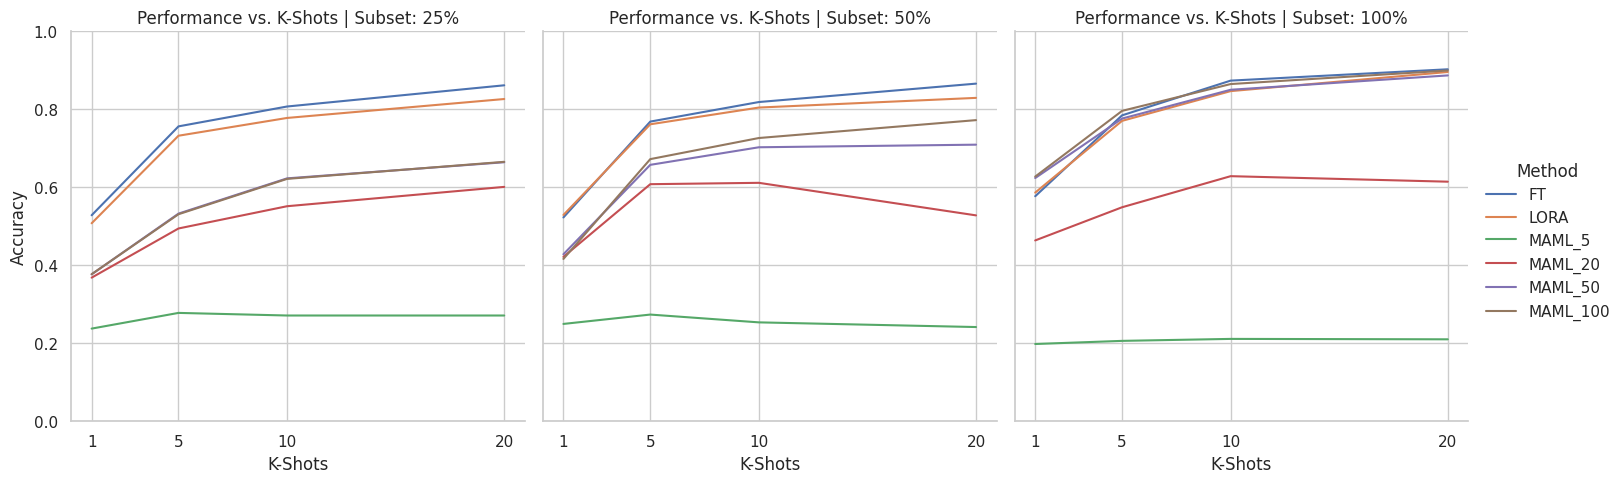

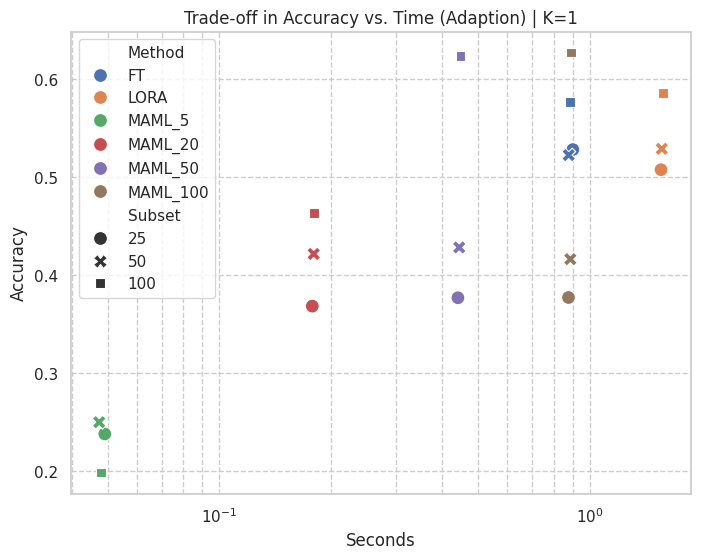

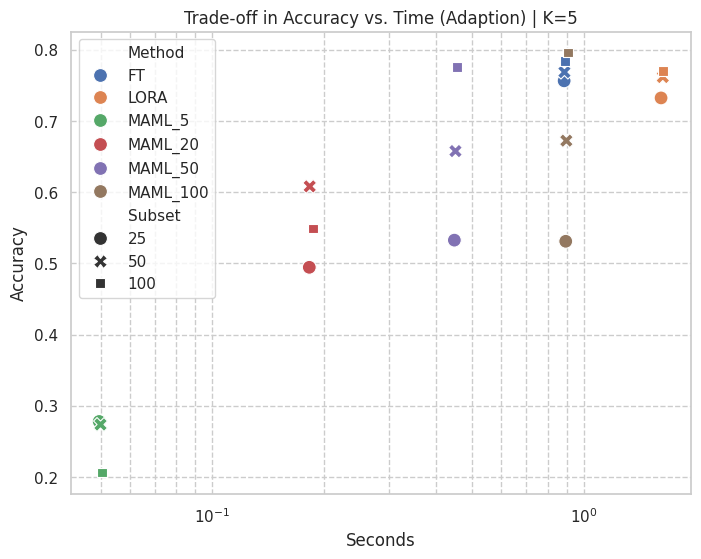

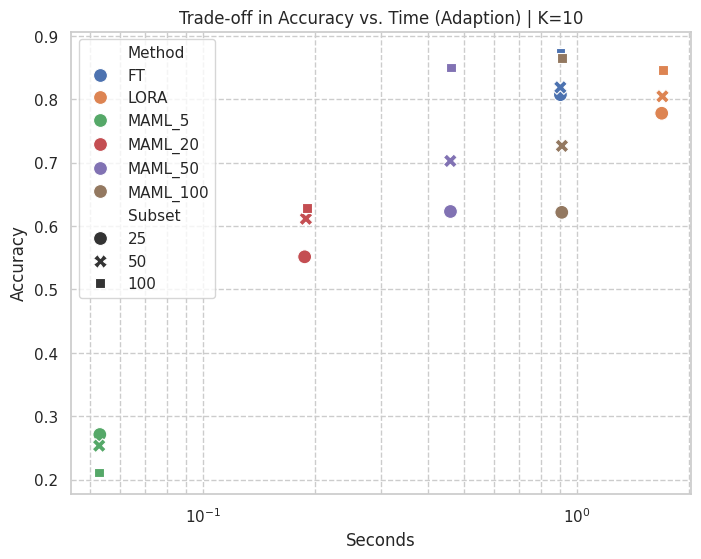

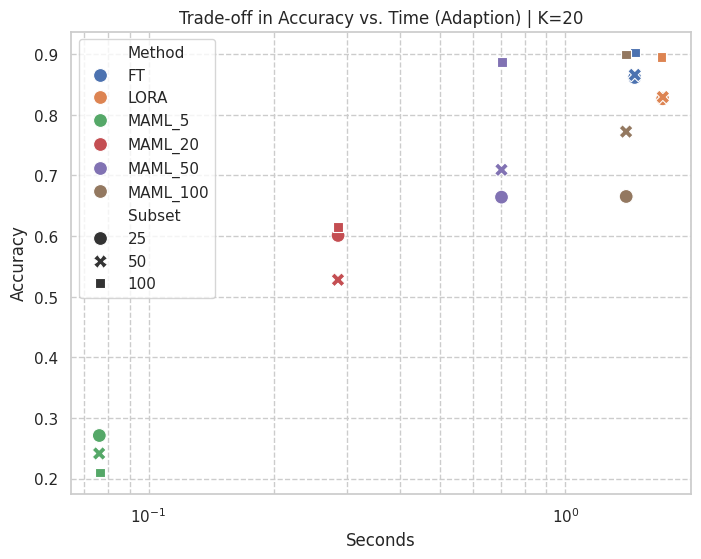

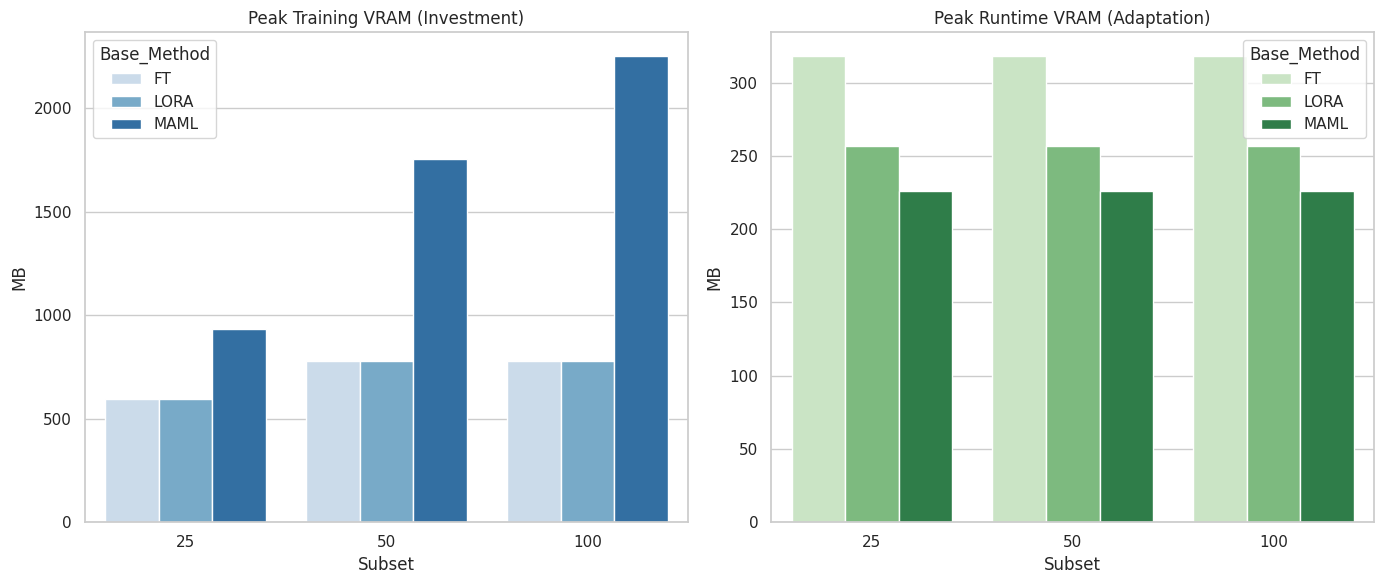

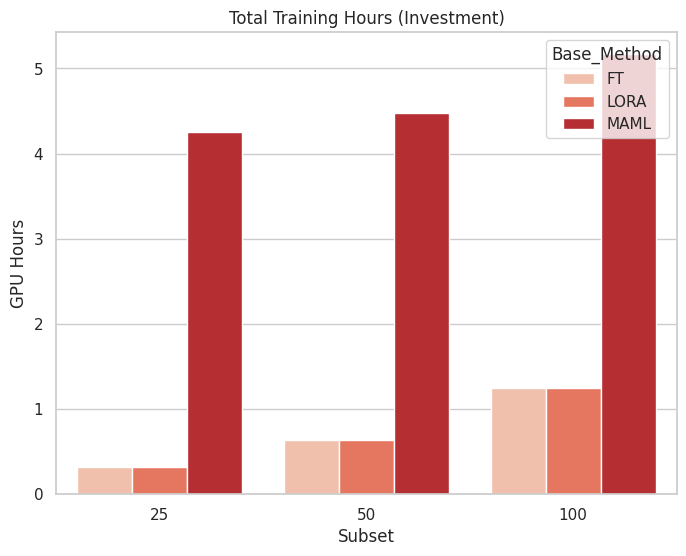

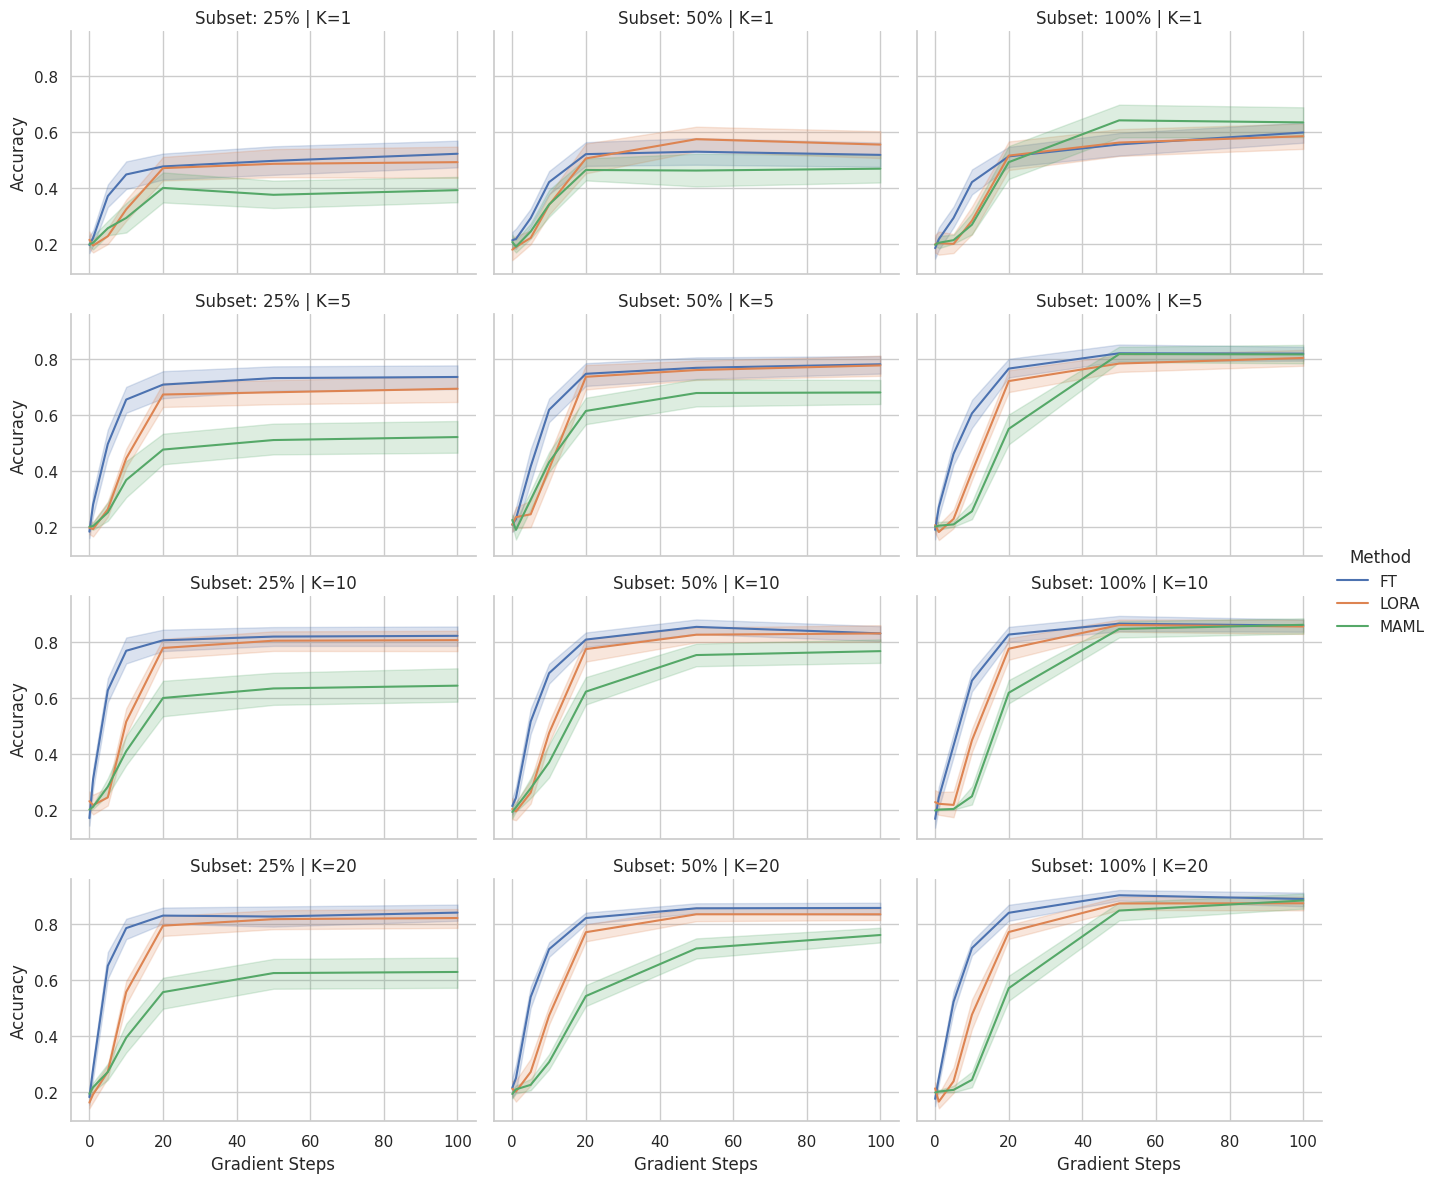


>>> DEEP DIVE: FAIL CASE ANALYSIS <<<


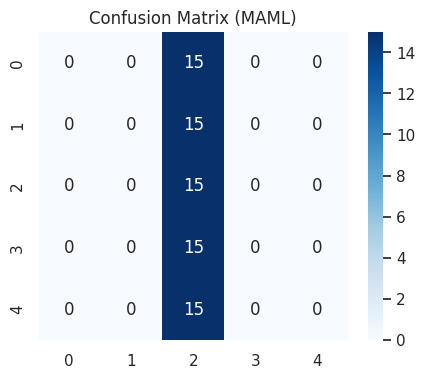

Found 60 errors. Showing top 5...


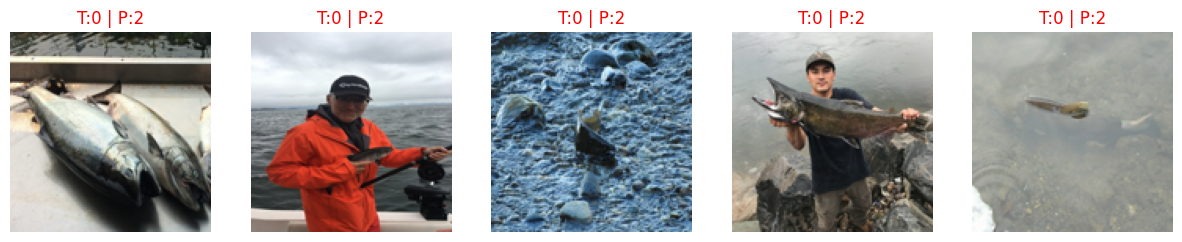

[INFO] Visualization Complete.


In [43]:
################################################################################
# PHASE 7c: VISUALIZATION (FINAL POLISHED PLOTS)
################################################################################
sns.set_theme(style="whitegrid")
run_suffix = "_dryrun" if EVAL_CONFIG['DRY_RUN'] else ""

csv_main = os.path.join(DIRS['LOGS'], f"Evaluation_Matrix_{CURRENT_ARCH}{run_suffix}_metrics.csv")
csv_curve = os.path.join(DIRS['LOGS'], f"Evaluation_Curves_{CURRENT_ARCH}{run_suffix}.csv")

print(f"\n--- PHASE 7: VISUALIZATION ({CURRENT_ARCH}) ---")

if os.path.exists(csv_main):
    df = pd.read_csv(csv_main)

    # --- 1. Performance vs K-Shots (Fixed Axis) ---
    try:
        g = sns.relplot(data=df, x="Shots", y="Acc", hue="Method", col="Subset", kind="line", markers=True, height=5, aspect=1)
        g.set_titles("Performance vs. K-Shots | Subset: {col_name}%")
        g.set(ylim=(0, 1.0))
        # Force integers on X-Axis
        for ax in g.axes.flat:
            ax.set_xticks([1, 5, 10, 20])
            ax.grid(True, which='major', axis='x') # Grid only on ticks
            ax.set_ylabel("Accuracy")
            ax.set_xlabel("K-Shots")

        plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_Performance{run_suffix}.png"))
        plt.show()
    except Exception as e: print(f"[WARN] Plot 1: {e}")

    # 2. Efficiency Trade-off (Per Shot)
    try:
      for k in df['Shots'].unique():
          df_k = df[df['Shots'] == k]
          plt.figure(figsize=(8, 6))
          sns.scatterplot(data=df_k, x="Time_sec", y="Acc", hue="Method", style="Subset", s=100)
          plt.xscale('log')
          plt.title(f"Trade-off in Accuracy vs. Time (Adaption) | K={k}")
          plt.grid(True, which="both", ls="--")
          plt.xlabel("Seconds")
          plt.ylabel("Accuracy")
          plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_TradeOff_K{k}{run_suffix}.png"))
          plt.show()
    except Exception as e: print(f"[WARN] Plot 2: {e}")

    # --- 2. VRAM Efficiency (Only relevant Methods) ---
    try:
        # We take K=5 as representative
        df_sub = df[(df['Shots'] == 5)].copy()
        # Group MAML_5, MAML_20... into just "MAML" for Training VRAM visualization
        # Because Training VRAM is identical for all MAML inference variants
        df_sub['Base_Method'] = df_sub['Method'].apply(lambda x: 'MAML' if 'MAML' in x else x)

        if not df_sub.empty:
            fig, ax = plt.subplots(1, 2, figsize=(14, 6))

            # A. Training VRAM (Investment) - Deduplicated
            df_train_vram = df_sub.drop_duplicates(subset=['Subset', 'Base_Method'])
            sns.barplot(data=df_train_vram, x="Subset", y="Train_VRAM_MB", hue="Base_Method", ax=ax[0], palette="Blues")
            ax[0].set_title("Peak Training VRAM (Investment)")
            ax[0].set_ylabel("MB")

            # B. Adaptation VRAM (Runtime) - All Variants
            # Filter to keep plot clean? No, show all.
            df_adapt_vram = df_sub.drop_duplicates(subset=['Subset', 'Base_Method'])
            sns.barplot(data=df_adapt_vram, x="Subset", y="VRAM_MB", hue="Base_Method", ax=ax[1], palette="Greens")
            ax[1].set_title("Peak Runtime VRAM (Adaptation)")
            ax[1].set_ylabel("MB")

            plt.tight_layout()
            plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_VRAM{run_suffix}.png"))
            plt.show()
    except Exception as e: print(f"[WARN] Plot 3 (VRAM): {e}")

    # --- 3. Investment Time (Deduplicated) ---
    try:
        # Deduplicate by Base Method (MAML_5 and MAML_20 share same training time)
        df_cost = df.drop_duplicates(subset=['Subset', 'Base_Method'])

        plt.figure(figsize=(8, 6))
        sns.barplot(data=df_cost, x="Subset", y="Train_Time_Hours", hue="Base_Method", palette="Reds")
        plt.title("Total Training Hours (Investment)")
        plt.ylabel("GPU Hours")
        plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_Investment{run_suffix}.png"))
        plt.show()
    except Exception as e: print(f"[WARN] Plot 4: {e}")

# --- 4. Learning Curve (Labeled) ---
if os.path.exists(csv_curve):
    try:
        df_c = pd.read_csv(csv_curve)
        g = sns.relplot(data=df_c, x="Steps", y="Acc", hue="Method", col="Subset", row="K_Shot", kind="line", markers=True, height=3, aspect=1.5)
        g.set_titles("Subset: {col_name}% | K={row_name}")
        g.set_axis_labels("Gradient Steps", "Accuracy")
        plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_LearningCurve{run_suffix}.png"))
        plt.show()
    except Exception as e: print(f"[WARN] Plot 5: {e}")

# --- 5. Deep Dive (Fail Cases) ---
print("\n>>> DEEP DIVE: FAIL CASE ANALYSIS <<<")

try:
    # Try to load MAML 100 model
    model = load_m_maml(1.0)
    method = 'MAML'
    params = {'LR': 0.01, 'STEPS': 5}

    # Fallback to FT if MAML missing
    if not model:
        print("[INFO] MAML model not found, falling back to FT for Deep Dive.")
        model = load_m_base(1.0)
        method = 'FT'
        params = WINNERS['M_base_100']['FT']

    if model and 'task_gen' in globals():
        sX, sY, qX, qY = task_gen.get_task(5, 5, 15)
        sX, sY, qX, qY = sX.to(DEVICE), sY.to(DEVICE), qX.to(DEVICE), qY.to(DEVICE)

        # We need the updated measure function that returns images
        # If Block 1 was not re-run, this might crash with "too many values to unpack"
        # We handle this gracefully
        ret = measure_adaptation(model, sX, sY, qX, qY, method, params)

        if len(ret) == 4:
            _, _, _, (preds, trues, q_imgs) = ret

            # Confusion Matrix
            cm = confusion_matrix(trues.cpu().numpy(), preds.cpu().numpy())
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"Confusion Matrix ({method})")
            plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_DeepDive_CM{run_suffix}.png"))
            plt.show()

            # Fail Cases
            p_np = preds.cpu().numpy()
            t_np = trues.cpu().numpy()
            failures = [i for i in range(len(p_np)) if p_np[i] != t_np[i]]

            if failures:
                print(f"Found {len(failures)} errors. Showing top 5...")
                fig, axes = plt.subplots(1, min(5, len(failures)), figsize=(15, 3))
                if len(failures) == 1: axes = [axes] # Ensure iterable

                def denorm(t):
                    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(DEVICE)
                    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(DEVICE)
                    return (t * std + mean).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

                for i, idx in enumerate(failures[:5]):
                    ax = axes[i]
                    ax.imshow(denorm(qX[idx]))
                    ax.axis('off')
                    ax.set_title(f"T:{t_np[idx]} | P:{p_np[idx]}", color='red')
                plt.savefig(os.path.join(DIRS['PLOTS'], f"P7_DeepDive_Fail{run_suffix}.png"))
                plt.show()
            else:
                print("Perfect Score on this random task!")
        else:
            print("[WARN] measure_adaptation returned old format (3 values). Please re-run Block 1 to enable Deep Dive images.")

except Exception as e:
    print(f"[SKIP] Deep Dive failed: {e}")

print("[INFO] Visualization Complete.")